
### AdultData: Fairness & Repair Exploratory Analysis - Kushagra Ghosh

In data cleaning, the objective is to ensure that data can adhere to the right quality and integrity constraints. Our data has constraints (functional dependencies or FDs) that we want the database to satisfy (such as Zip Code -> City, State). There are countless algorithms for data repair that take in data and delete tuples, change values, or add different tuples to satisfy FDs using ML and statistics about the data. However, by changing the data, these repair algorithms may hurt one population. For example, by deleting a higher proportion of female tuples, there may be a lower percentage of females in the final data, swaying our statistics and create bias. We would like to verify our assumption that data repair algorithms can introduce bias. 

The idea of this exploration exercise is to see how query answers differ after specific data transformations. Specifically, does the data become distorted due to these transformations and then may lead the analyst to the wrong conclusion due to bias? 

Our data comes from the AdultFull dataset from the HoloClean repository (https://github.com/HoloClean/holoclean/blob/master/testdata/AdultFull.csv). 

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
url = "https://raw.githubusercontent.com/HoloClean/holoclean/master/testdata/AdultFull.csv"
df = pd.read_csv(url)
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
display(df.head())

,Age,Workclass,Education,Maritalstatus,Occupation,Relationship,Race,Sex,HoursPerWeek,Country,Income
0,31-50,private,some-college,married-civ-spouse,craft-repair,husband,white,male,40,united-states,lessthan50k
1,>50,federal-gov,some-college,never-married,exec-managerial,own-child,black,female,40,united-states,lessthan50k
2,31-50,private,bachelors,married-civ-spouse,sales,husband,white,male,50,united-states,lessthan50k
3,22-30,self-emp-inc,hs-grad,never-married,craft-repair,own-child,white,male,40,united-states,lessthan50k
4,22-30,private,hs-grad,married-civ-spouse,farming-fishing,husband,white,female,40,united-states,lessthan50k


I generated a stratified random sample with approximately 50% or 40% percentage for sex, and representation for different protected subpopulations (such as different races). I did this by dividing the AdultFull dataset into strata based on sex, and then randomly sampling from each stratum. 

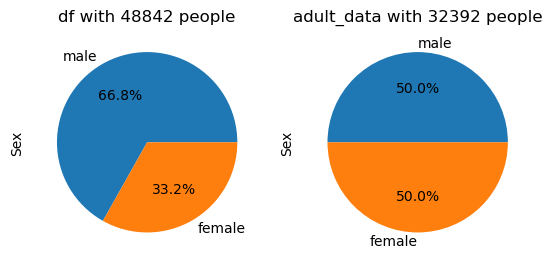

In [6]:
def piechart(title, df, ax, column):
    df[column].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax)
    ax.set_title(title)
    
df_males = df[df['Sex'] == 'male']
df_females = df[df['Sex'] == 'female']

num_rows = min(len(df_males), len(df_females))
male_sample = df_males.sample(n=num_rows)
female_sample = df_females.sample(n=num_rows)

adult_data = pd.concat([male_sample, female_sample])

fig, axs = plt.subplots(1, 2)
piechart(f"df with {df.shape[0]} people", df, axs[0], 'Sex')
piechart(f"adult_data with {adult_data.shape[0]} people", adult_data, axs[1], 'Sex')
plt.show()

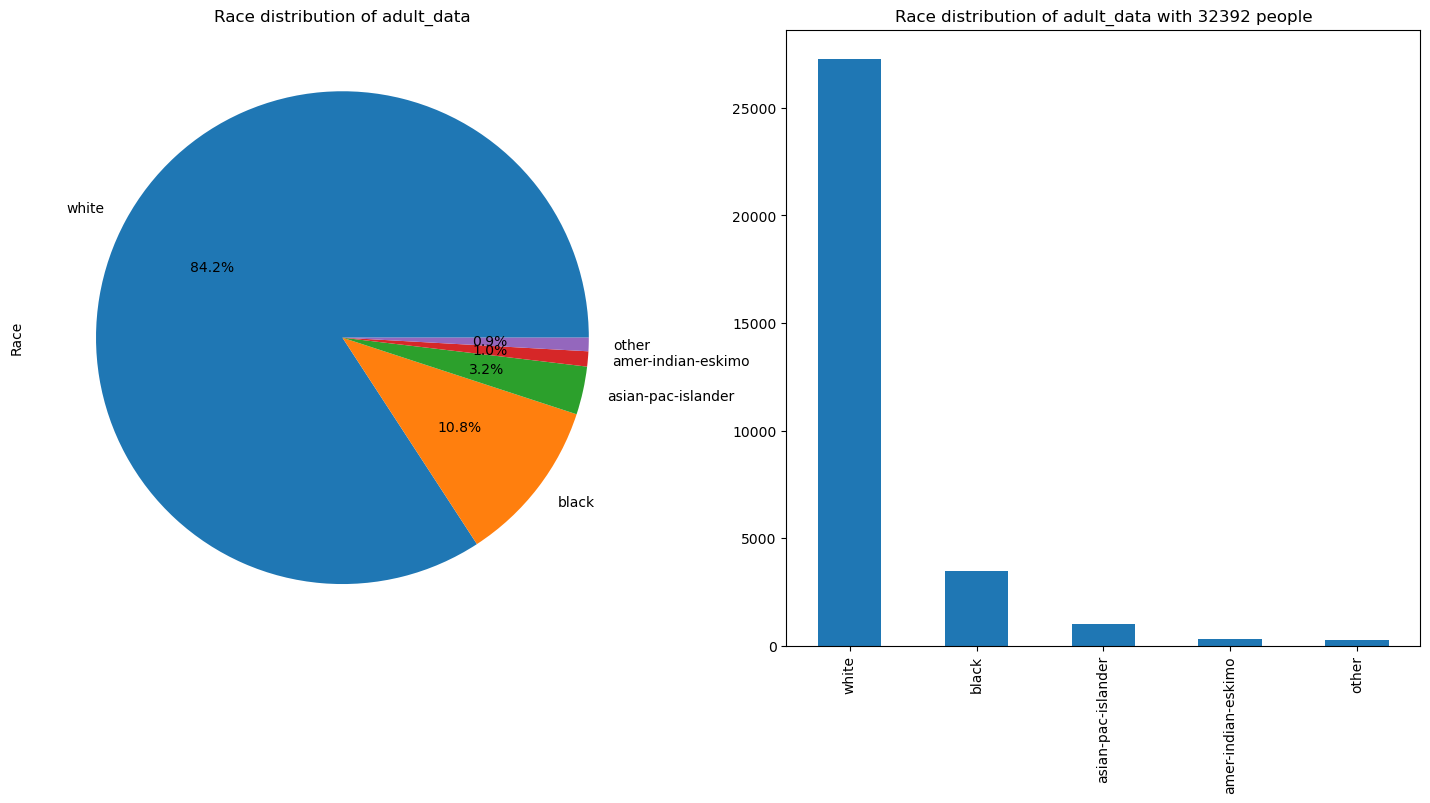

In [4]:
def barplotForCounts(title, df, ax, column):
    df[column].value_counts().plot(kind="bar", ax=ax)
    #display(df[column].value_counts())
    ax.set_title(title)
    

fig, axs = plt.subplots(1,2, figsize=(18,8))
piechart("Race distribution of adult_data", adult_data, axs[0], 'Race')
barplotForCounts(f"Race distribution of adult_data with {adult_data.shape[0]} people", adult_data, axs[1], 'Race')

plt.show()

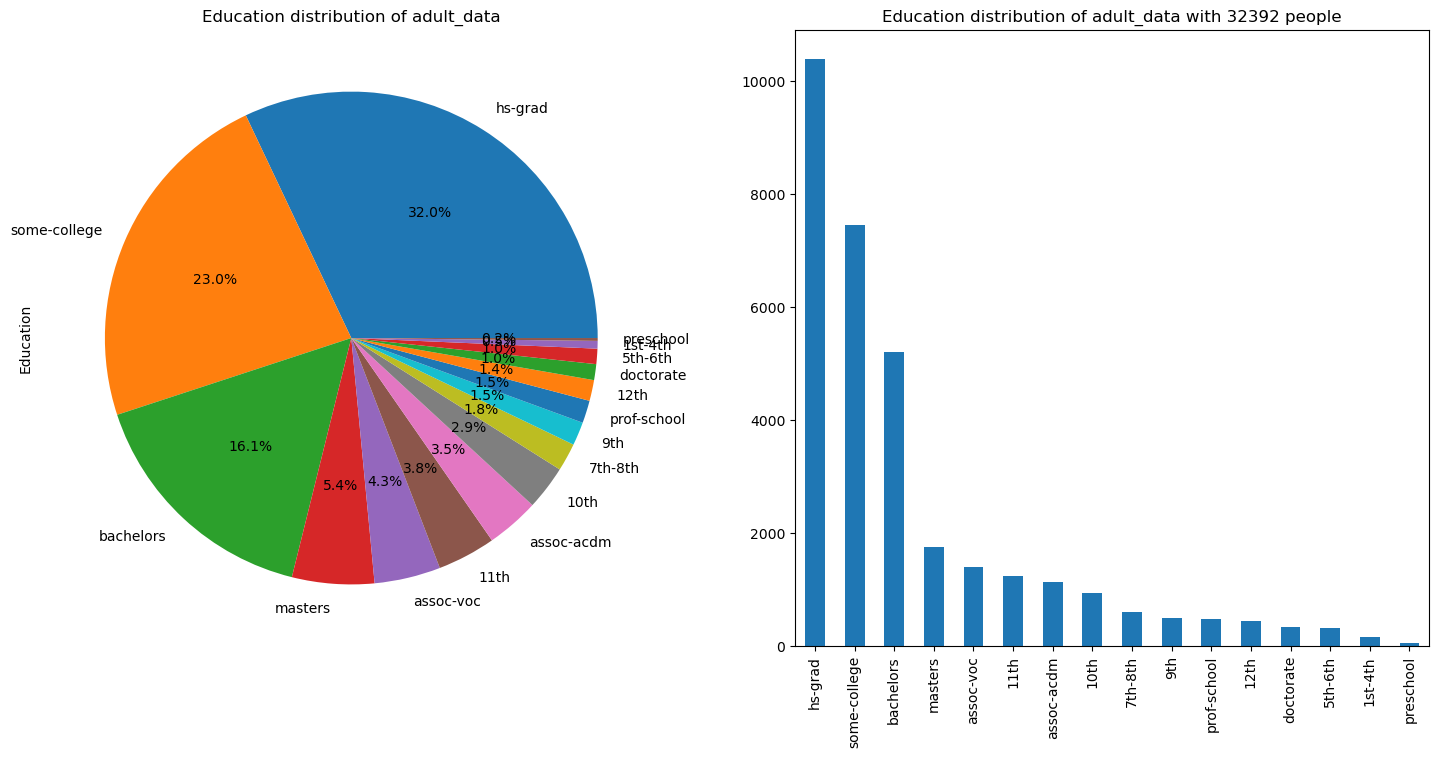

In [5]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
piechart("Education distribution of adult_data", adult_data, axs[0], 'Education')
barplotForCounts(f"Education distribution of adult_data with {adult_data.shape[0]} people", adult_data, axs[1], 'Education')
plt.show()

Then, I binarized the Income column (0 = a person makes < 50K a year and 1 = a person makes > 50K a year). I computed the average of the IncomeBinary column (the average of the binary income column is the proportion of people making > 50k a year) for the entire population. 

In [6]:
adult_data['IncomeBinary'] = adult_data['Income'].apply(lambda x: 1 if x == 'morethan50k' else 0)
avg_income = np.mean(adult_data['IncomeBinary'])

print(f"Proportion of people making > 50K a year in adult_data: {avg_income:.4f}")

Proportion of people making > 50K a year in adult_data: 0.2061


I computed the average of the IncomeBinary column (the average of the binary income column is the proportion of people making > 50k a year) for different protected subpopulations (different sexes, different races) as well as for different education. 

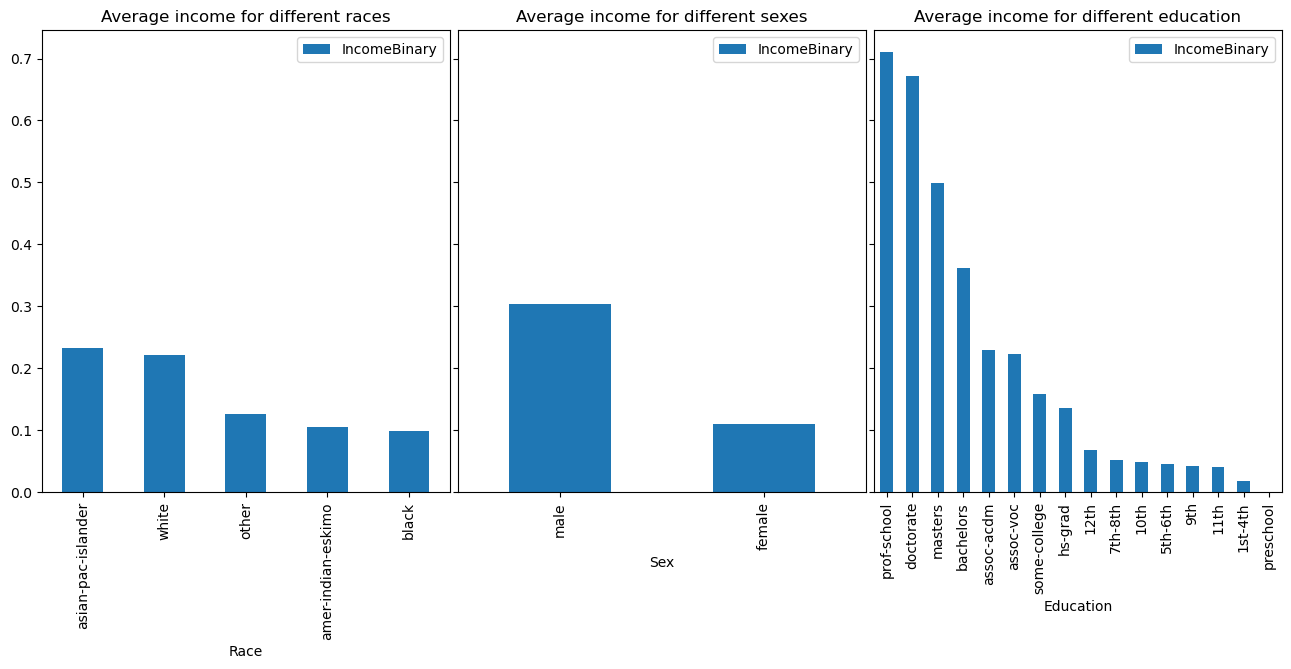

In [7]:
def barplotForAvg(title, df, column, ax):
    df.pivot_table(values='IncomeBinary', index=column, aggfunc='mean').sort_values(ascending=False, by='IncomeBinary').plot.bar(ax=ax)
    #display(df.pivot_table(values='IncomeBinary', index=column, aggfunc='mean').sort_values(ascending=False, by='IncomeBinary'))
    #ax.axhline(avg_income, color='red', linewidth=2)
    ax.set_title(title)
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Average income for different races", adult_data, 'Race', axs[0])
barplotForAvg("Average income for different sexes", adult_data, 'Sex', axs[1])
barplotForAvg("Average income for different education", adult_data, 'Education', axs[2])

fig.subplots_adjust(wspace=0.02)
plt.show()

Then, I found a functional dependency (FD) that is satisfied by the data using https://github.com/USEPA/FDTool.

In [8]:
adult_data.to_csv('adult_data.csv',index=False)

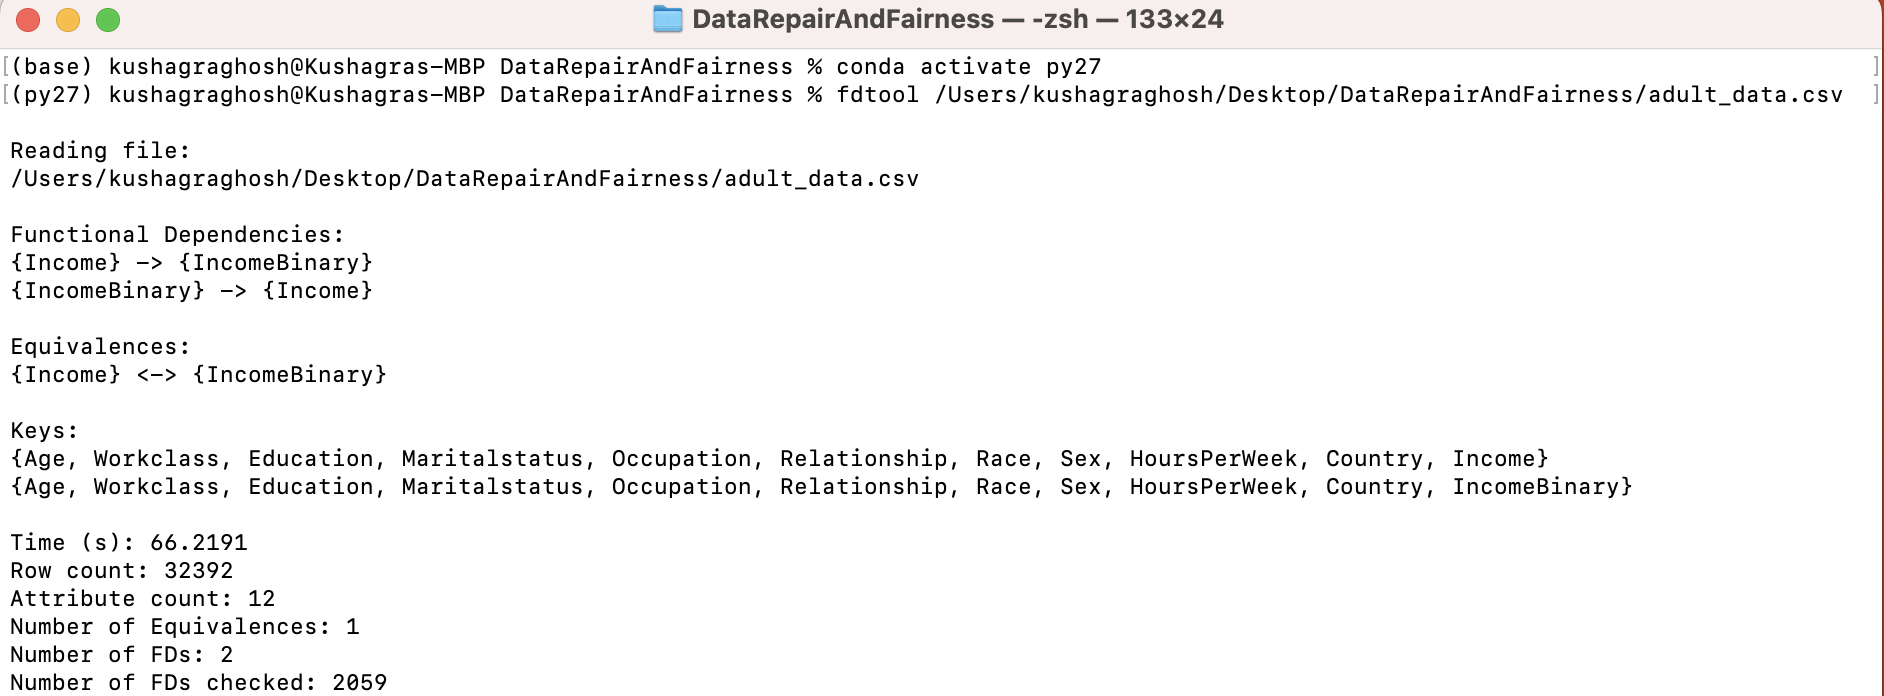

I also found denial constraints (DC) in the data, which was a set of predicates that can't hold true simultaneously. I verified that the FD and DCs makes sense and that the data doesn't violate the FD and DC before moving to the next step. 

In [9]:
def satisfiesFD(df, col1, col2):
    return df.groupby([col1])[col2].nunique().eq(1).all()

print(satisfiesFD(adult_data,'Income','IncomeBinary'))

def satisfiesDC(df, col1, val1, col2, val2):
    return df[df[col1] == val1][col2].eq(val2).sum() == 0

print(satisfiesDC(adult_data,'Sex','female','Relationship','husband'))
print(satisfiesDC(adult_data,'Sex','male','Relationship','wife'))

True
False
False


Then, I will generated synthetic data (with a machine learning model), which changes the values of the tuple but maintains the same number of tuples. With my new synthetic adult data, I will check how many violations of the Functional Dependencies and Denial Constraints I find, and how the various marginal distributions for income based on race, gender, education, and more is affected.

In [10]:
%%capture
pip install sdv

For the first synthetic data being generated from the original data (adult_data), I decided to only use metadata about the numerical or categorical type of each attribute, and chose to specifically omit constraints such as the FixedConstraints (which is as close to Denial Constraints as the SDV package offers). I will add these constraints in my later synthetic data generators that use the original data (adult_data) and several constraints I can observe in the data.

In [11]:
from sdv.metadata import SingleTableMetadata
adult_data = adult_data.replace('?', None)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=adult_data)

I experimented with using several synthetic data generators (from the Synthetic Data Vault package found at https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers) using various Copulas and Deep Learning based models. Finally, I used the FAST ML Preset synthesizer from https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/fast-ml-preset to generate new synthetic data from the original data (adult_data) due to its quicker runtime and more accurate distributions compared to the original dataset. 

In [12]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name='FAST_ML')
synthesizer.fit(adult_data)

The size of the generated data matches the size of the initial data.

In [13]:
synthetic_data = synthesizer.sample(num_rows=adult_data.shape[0])
display(synthetic_data)

,Age,Workclass,Education,Maritalstatus,Occupation,Relationship,Race,Sex,HoursPerWeek,Country,Income,IncomeBinary
0,22-30,private,some-college,never-married,prof-specialty,unmarried,white,female,45,united-states,lessthan50k,0
1,22-30,private,bachelors,never-married,other-service,not-in-family,white,female,60,united-states,lessthan50k,0
2,18-21,private,assoc-voc,married-af-spouse,other-service,other-relative,white,female,40,united-states,lessthan50k,0
3,31-50,private,some-college,married-civ-spouse,other-service,not-in-family,white,male,40,united-states,lessthan50k,0
4,22-30,private,some-college,never-married,exec-managerial,husband,white,female,40,united-states,lessthan50k,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32387,<18,private,bachelors,divorced,adm-clerical,not-in-family,white,male,60,united-states,lessthan50k,0
32388,22-30,private,hs-grad,never-married,transport-moving,own-child,white,female,5,united-states,lessthan50k,0
32389,22-30,private,hs-grad,never-married,prof-specialty,own-child,white,male,40,united-states,lessthan50k,0
32390,22-30,private,masters,never-married,sales,unmarried,white,male,40,united-states,lessthan50k,0


Then, I checked if the generated data satisfies the functional dependency. I check if two columns form a FD by comparing the values at both columns for each tuple and checking if one column uniquely determined the other column. 

Given two columns Income and IncomeBinary, the approach I implemented is to first group by the values of the Income column and use the nunique() method to check number of unique values in IncomeBinary for each group in the Income column. If all of the values are 1, that means that there is a unique value for IncomeBinary for each each value in Income, which means that columns Income and IncomeBinary conform to a functional dependency.

In [14]:
print("For the functional dependency between Income -> IncomeBinary:")
print(f"The adult_data satisfies FD: {satisfiesFD(adult_data,'Income','IncomeBinary')}\nThe synthetic_data satisfies FD: {satisfiesFD(synthetic_data,'Income','IncomeBinary')}")

print("\nFor the denial constraint between the specific values of Sex and Relationship:")
print(f"The adult_data satisfies DC: {satisfiesDC(adult_data,'Sex','female','Relationship','husband')}\nThe synthetic_data satisfies DC: {satisfiesDC(synthetic_data,'Sex','female','Relationship','husband')}")

For the functional dependency between Income -> IncomeBinary:
The adult_data satisfies FD: True
The synthetic_data satisfies FD: False

For the denial constraint between the specific values of Sex and Relationship:
The adult_data satisfies DC: False
The synthetic_data satisfies DC: False


I also checked how many violations of the FDs are in the data. (i.e., how many pairs of tuples violate it) to quantify how noisy the new synthetic data is. In order to do this, I did a projection on my dataframe to get the relevant columns for the FD, and then I did a self join query with the column in the left side of the FD being equal but the column in the right side of the FD being not equal (for example for Col1 -> Col2, I set the join condition as A.Col1 = B.Col1 and A.Col2 != B.Col2). 

Then I counted how many tuples form a violation the new merged table, and divided this number by the maximum number of ways of joining two tuples together. This number is equal to the maximum number of violations possible in the new merge table, which turns out to be $tuples\space in \space original \space dataframe \choose 2$ . 

In [157]:
import math

merging_data = synthetic_data[['Income','IncomeBinary']]
num_rows = merging_data.shape[0]
maxViolations = math.comb(num_rows,2)

merging_data = merging_data.reset_index()
merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)

result = pd.merge(merging_data, merging_data, how='inner', left_on=['Income'], right_on=['Income'], suffixes=('_left', '_right'))
result = result[result['index_left'] > result['index_right']]
result = result[result['IncomeBinary_left'] != result['IncomeBinary_right']]
num_violations = result.shape[0]
print(f"{num_violations} pairs of tuples violate the Income -> IncomeBinary FD. The maximum possible violations are {maxViolations}. The percentage is {num_violations/maxViolations:.3%}")

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_13780/3246153990.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


110289576 pairs of tuples violate the Income -> IncomeBinary FD. The maximum possible violations are 524604636. The percentage is 21.023%


Then, I repeated my earlier step for the new synthetic data generated: I recomputed the average income (the proportion of people making > 50k a year) for the entire population and for different protected subpopulations (different sexes, different races).  

In [15]:
print(f"Proportion of people making > 50k a year in adult_data: {avg_income:.4f}".format(avg_income))
avg_income_synthetic = np.mean(synthetic_data['IncomeBinary'])
print(f"Proportion of people making > 50k a year in new synthetic_data: {avg_income_synthetic:.4f}")

Proportion of people making > 50k a year in adult_data: 0.2061
Proportion of people making > 50k a year in new synthetic_data: 0.2370


I compared the marginal distributions of average IncomeBinary from the original data and the synthetic data. First, I compared the race distributions (counts) in original data (adult_data) and new synthetic data (synthetic_data).

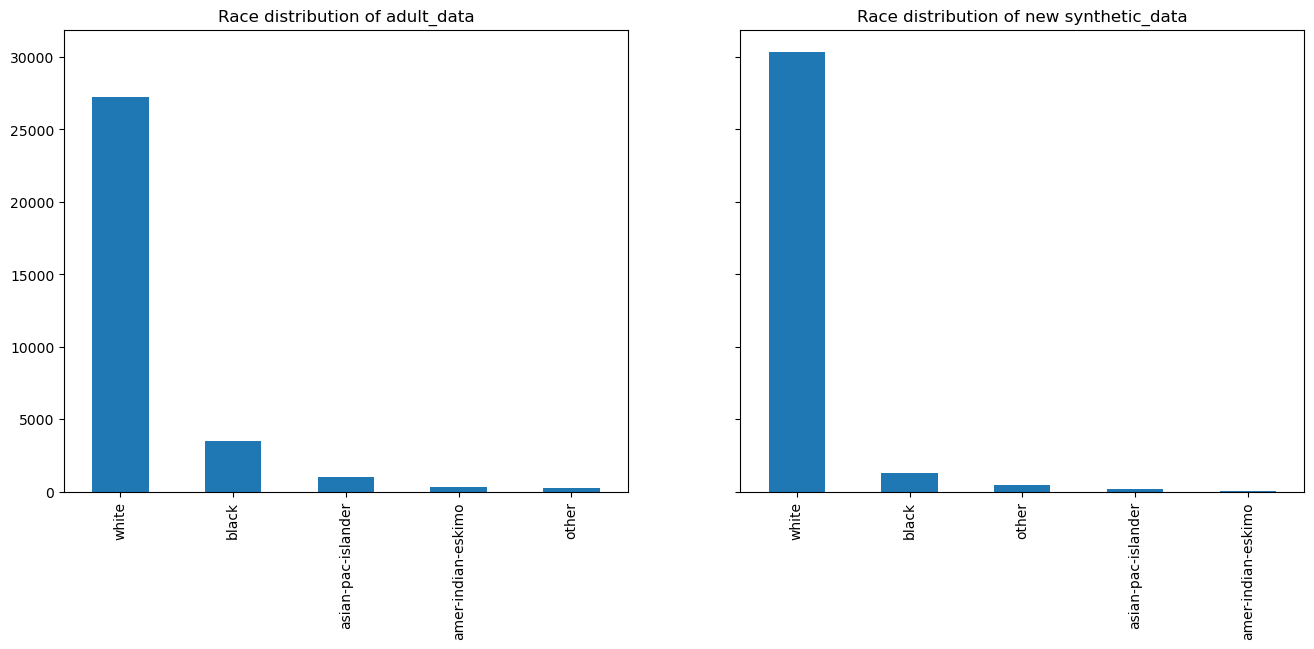

In [16]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
barplotForCounts(f"Race distribution of adult_data", adult_data, axs[0], 'Race')
barplotForCounts(f"Race distribution of new synthetic_data", synthetic_data, axs[1], 'Race')

plt.show()

I compared the average income (Proportion of people making > 50K a year) for different races in original data (adult_data) and new synthetic data (synthetic_data).

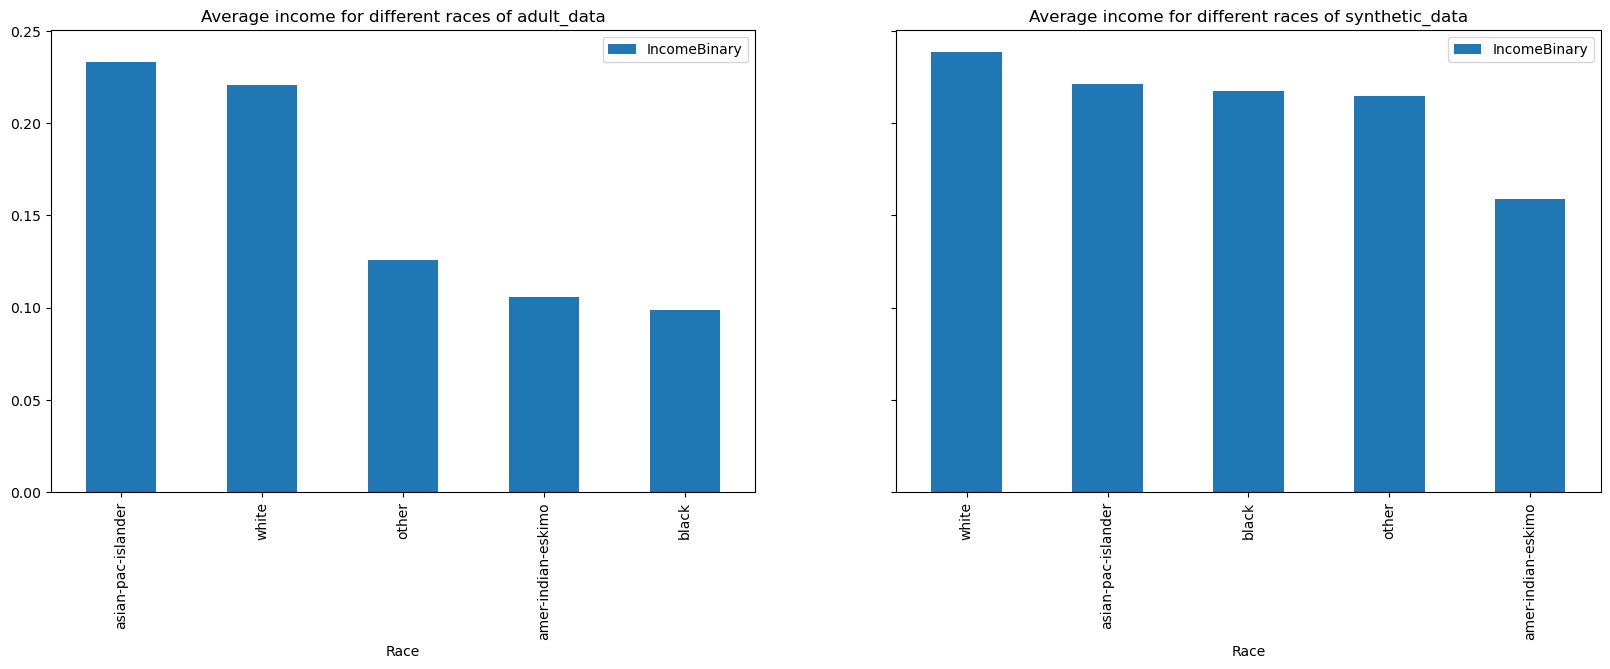

In [17]:
fig, axs = plt.subplots(1,2, figsize=(20,6), sharey=True)
barplotForAvg("Average income for different races of adult_data", adult_data, 'Race', axs[0])
barplotForAvg("Average income for different races of synthetic_data", synthetic_data, 'Race', axs[1])
plt.show()

I compared the sex distributions in original data (adult_data) and new synthetic data (synthetic_data).

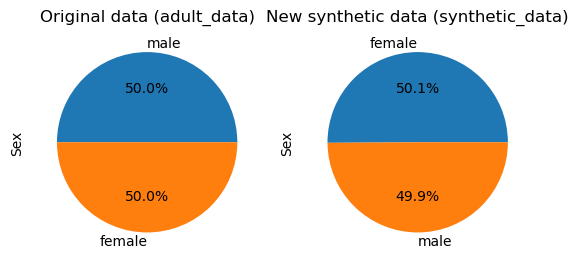

In [18]:
fig, axs = plt.subplots(1, 2)
piechart(f"Original data (adult_data)", adult_data, axs[0], 'Sex')
piechart(f"New synthetic data (synthetic_data)", synthetic_data, axs[1], 'Sex')
plt.show()

I compared the average income for different sexes in original data (us_data) and new synthetic data (new_data)

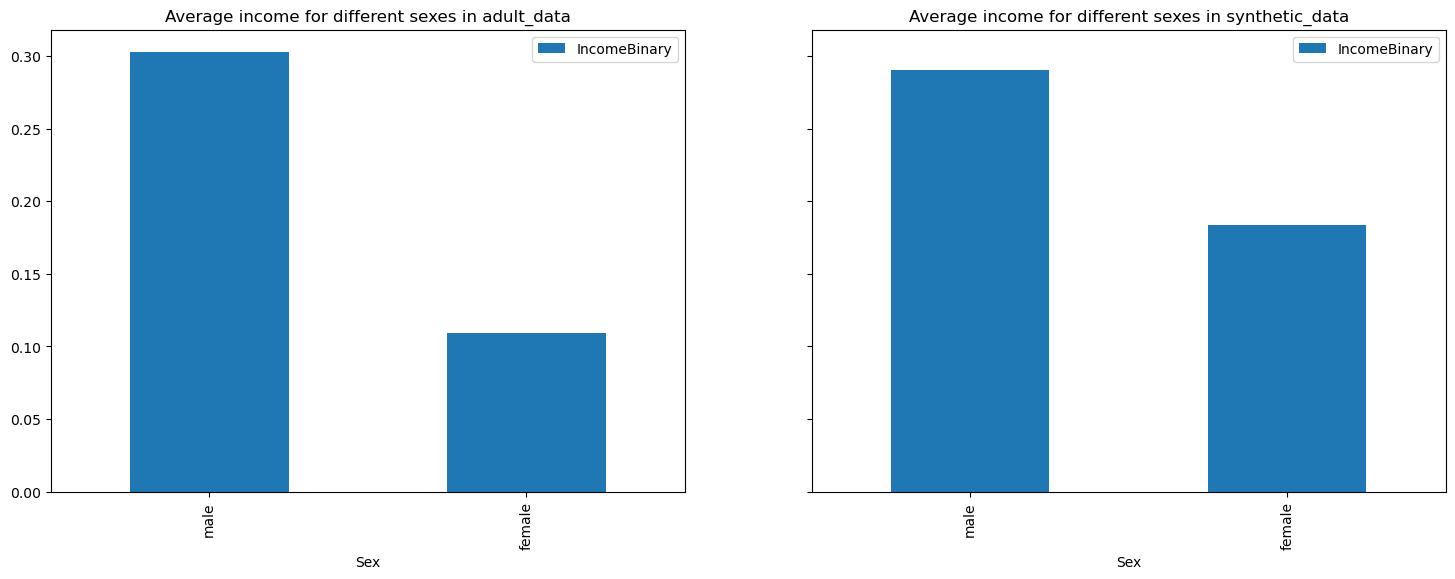

In [19]:
fig, axs = plt.subplots(1,2, figsize=(18,6), sharey=True)
barplotForAvg("Average income for different sexes in adult_data", adult_data, 'Sex', axs[0])
barplotForAvg("Average income for different sexes in synthetic_data", synthetic_data, 'Sex', axs[1])
plt.show()

I compared the education distributions (counts) in original data (adult_data) and new synthetic data (synthetic_data).

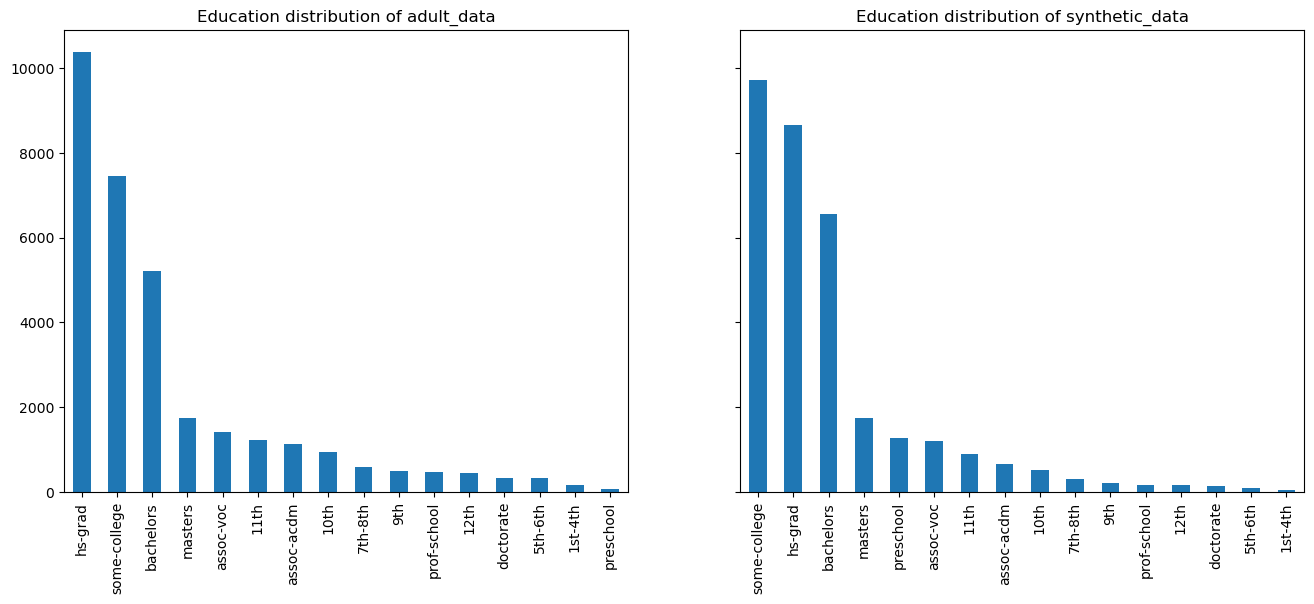

In [20]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
barplotForCounts(f"Education distribution of adult_data", adult_data, axs[0], 'Education')
barplotForCounts(f"Education distribution of synthetic_data", synthetic_data, axs[1], 'Education')
plt.show()

I compared the average income for different regions in original data (adult_data) and new synthetic data (synthetic_data).

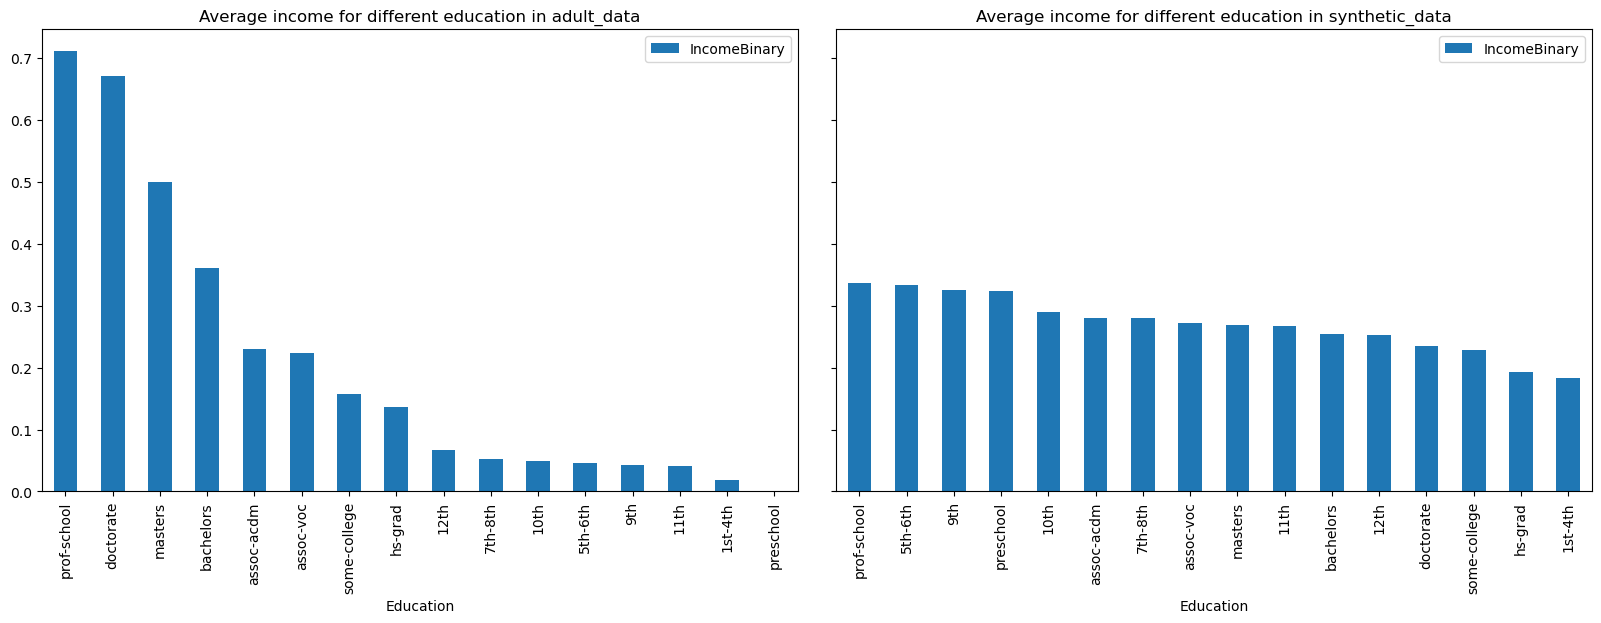

In [21]:
fig, axs = plt.subplots(1,2, figsize=(20,6), sharey=True)
barplotForAvg("Average income for different education in adult_data", adult_data, 'Education', axs[0])
barplotForAvg("Average income for different education in synthetic_data", synthetic_data, 'Education', axs[1])
fig.subplots_adjust(wspace=0.05)
plt.show()

Afterwards, I compared the original data and synthetic data further by comparing the percent of females earning above 50k, percent of males earning above 50k, and percent of southerners earning above 50k. 

In [22]:
female_original = adult_data[adult_data['Sex']=='female']
female_original_above50k = female_original.loc[female_original['Income'] == 'morethan50k']
female_synthetic = synthetic_data[synthetic_data['Sex']=='female']
female_synthetic_above50k = female_synthetic.loc[female_synthetic['Income'] == 'morethan50k']

print(f"Percent of females earning above 50k in original data (adult_data): {female_original_above50k.shape[0]}/{female_original.shape[0]} = {female_original_above50k.shape[0]/female_original.shape[0]:.3%}")
print(f"Percent of females earning above 50k in synthetic data (synthetic_data): {female_synthetic_above50k.shape[0]}/{female_synthetic.shape[0]} = {female_synthetic_above50k.shape[0]/female_synthetic.shape[0]:.3%}")

Percent of females earning above 50k in original data (adult_data): 1771/16196 = 10.935%
Percent of females earning above 50k in synthetic data (synthetic_data): 1269/16227 = 7.820%


In [23]:
male_original = adult_data[adult_data['Sex']=='male']
male_original_above50k = male_original.loc[male_original['Income'] == 'morethan50k']
male_synthetic = synthetic_data[synthetic_data['Sex']=='male']
male_synthetic_above50k = male_synthetic.loc[male_synthetic['Income'] == 'morethan50k']

print(f"Percent of males earning above 50k in original data (adult_data): {male_original_above50k.shape[0]}/{male_original.shape[0]} = {male_original_above50k.shape[0]/male_original.shape[0]:.3%}")
print(f"Percent of males earning above 50k in synthetic data (synthetic_data): {male_synthetic_above50k.shape[0]}/{male_synthetic.shape[0]} = {male_synthetic_above50k.shape[0]/male_synthetic.shape[0]:.3%}")

Percent of males earning above 50k in original data (adult_data): 4906/16196 = 30.291%
Percent of males earning above 50k in synthetic data (synthetic_data): 2142/16165 = 13.251%


In [24]:
doctorate_original = adult_data[adult_data['Education']=='doctorate']
doctorate_original_above50k = doctorate_original.loc[doctorate_original['Income'] == 'morethan50k']
doctorate_synthetic = synthetic_data[synthetic_data['Education']=='doctorate']
doctorate_synthetic_above50k = doctorate_synthetic.loc[doctorate_synthetic['Income'] == 'morethan50k']

print(f"Percent of doctorates earning above 50k in original data (us_data): {doctorate_original_above50k.shape[0]}/{doctorate_original.shape[0]} = {doctorate_original_above50k.shape[0]/doctorate_original.shape[0]:.3%}")
print(f"Percent of doctorates earning above 50k in synthetic data (new_data): {doctorate_synthetic_above50k.shape[0]}/{doctorate_synthetic.shape[0]} = {doctorate_synthetic_above50k.shape[0]/doctorate_synthetic.shape[0]:.3%}")

Percent of doctorates earning above 50k in original data (us_data): 227/338 = 67.160%
Percent of doctorates earning above 50k in synthetic data (new_data): 12/132 = 9.091%


What we can conclude is that synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data perfectly. When I added metadata about the categorical or numerical nature of each of the attributes, then the distribution of the synthetic data loosely resembled the original distribution, but there is still an overrepresentation of the 'White' race category, and underepresentation in other race categories such as 'Black' that may have contributed to the overall increase in average income from the original data to the new synthetic data. There is also major inconsistencies in the marginal distributions of average income based on race and education in the original and synthetic data. Clearly there is a need to specify integrity constraints and functional dependencies in synthetic data generation to fairly represent different protected subpopulations that appear less frequently in the original dataset.

I will test my claim about how synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data because they don't fairly represent different protected subpopulations that appear less frequently in the original dataset. I will test this by creating another synthetic data generator with the same metadata but now with a combination of functional dependencies that was not present in the first synthetic data generator (which was called 'synthesizer'). 

I used FixedCombinations (https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes) as a proxy for functional dependencies since FixedCombinations were one of the only constraints that the Synthetic Data Vault (SDV) generators take in that is closest to a FD (since they didn't have a way to explicitly define FDs).

In [25]:
metadata2 = SingleTableMetadata()
metadata2.detect_from_dataframe(data=adult_data)
metadata2.update_column(
    column_name='IncomeBinary',
    sdtype='categorical'
)

In [26]:
fd = [['Income', 'IncomeBinary']]

def FixedCombinationsConstraint(fds):
    constraints = []
    for fd in fds:
        constraint = {
            'constraint_class': 'FixedCombinations',
            'constraint_parameters': {
                'column_names': fd
            }
        }
        constraints.append(constraint)
    return constraints

In [27]:
synthesizer2 = SingleTablePreset(metadata2, name='FAST_ML')
synthesizer2.add_constraints(
    constraints=FixedCombinationsConstraint(fd)
)
synthesizer2.fit(adult_data)

In [28]:
synthetic_data2 = synthesizer2.sample(num_rows=adult_data.shape[0])
display(synthetic_data2)

Sampling rows: 100%|███████████████████| 32392/32392 [00:00<00:00, 59037.84it/s]


,Age,Workclass,Education,Maritalstatus,Occupation,Relationship,Race,Sex,HoursPerWeek,Country,Income,IncomeBinary
0,22-30,private,some-college,divorced,other-service,own-child,white,female,48,united-states,lessthan50k,0
1,22-30,self-emp-not-inc,assoc-voc,married-civ-spouse,sales,husband,white,male,40,united-states,morethan50k,1
2,22-30,self-emp-inc,hs-grad,married-civ-spouse,other-service,husband,white,male,3,united-states,lessthan50k,0
3,22-30,private,assoc-acdm,divorced,other-service,own-child,white,female,40,united-states,lessthan50k,0
4,22-30,private,some-college,never-married,sales,not-in-family,white,female,45,united-states,lessthan50k,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32387,22-30,private,assoc-acdm,divorced,other-service,own-child,black,female,40,mexico,lessthan50k,0
32388,>50,private,bachelors,never-married,prof-specialty,husband,white,female,43,united-states,lessthan50k,0
32389,>50,self-emp-not-inc,bachelors,married-civ-spouse,exec-managerial,not-in-family,white,female,18-21,united-states,lessthan50k,0
32390,>50,private,hs-grad,never-married,sales,not-in-family,white,male,35,united-states,lessthan50k,0


In [29]:
print("For the functional dependency between Income -> IncomeBinary:")
print(f"The adult_data satisfies FD: {satisfiesFD(adult_data,'Income','IncomeBinary')}\nThe synthetic_data satisfies FD: {satisfiesFD(synthetic_data,'Income','IncomeBinary')}.\nThe synthetic_data2 with constraints satisfies FD: {satisfiesFD(synthetic_data2,'Income','IncomeBinary')}")

print("\nFor the denial constraint between the specific values of Sex and Relationship:")
print(f"The adult_data satisfies DC: {satisfiesDC(adult_data,'Sex','female','Relationship','husband')}\nThe synthetic_data satisfies DC: {satisfiesDC(synthetic_data,'Sex','female','Relationship','husband')}.\nThe synthetic_data2 with constraints satisfies FD: {satisfiesDC(synthetic_data2,'Sex','female','Relationship','husband')}")

For the functional dependency between Income -> IncomeBinary:
The adult_data satisfies FD: True
The synthetic_data satisfies FD: False.
The synthetic_data2 with constraints satisfies FD: True

For the denial constraint between the specific values of Sex and Relationship:
The adult_data satisfies DC: False
The synthetic_data satisfies DC: False.
The synthetic_data2 with constraints satisfies FD: False


In [30]:
print(f"Proportion of people making > 50k a year in adult_data: {avg_income:.4f}".format(avg_income))
avg_income_synthetic = np.mean(synthetic_data['IncomeBinary'])
print(f"Proportion of people making > 50k a year in synthetic_data: {avg_income_synthetic:.4f}")
avg_income_synthetic2 = np.mean(synthetic_data2['IncomeBinary'])
print(f"Proportion of people making > 50k a year in synthetic_data2 with constraints: {avg_income_synthetic2:.4f}")

Proportion of people making > 50k a year in adult_data: 0.2061
Proportion of people making > 50k a year in synthetic_data: 0.2370
Proportion of people making > 50k a year in synthetic_data2 with constraints: 0.1054


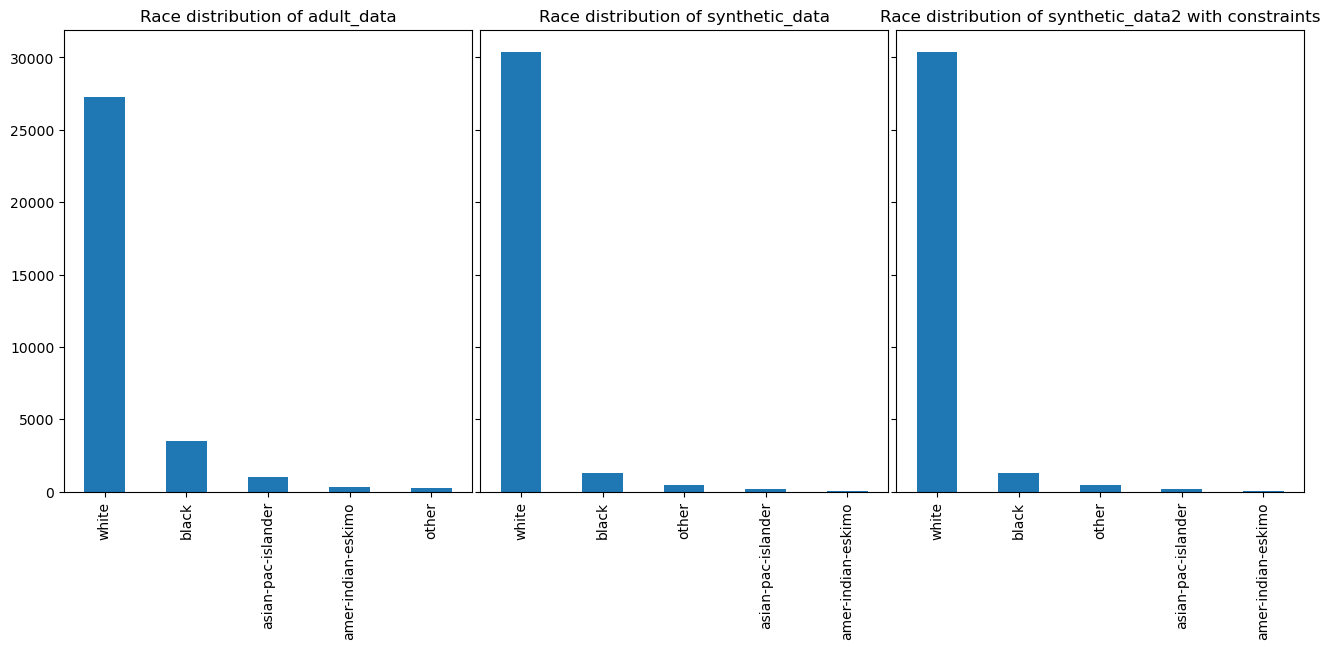

In [31]:
fig, axs = plt.subplots(1,3, figsize=(16,6), sharey=True)
barplotForCounts(f"Race distribution of adult_data", adult_data, axs[0], 'Race')
barplotForCounts(f"Race distribution of synthetic_data", synthetic_data, axs[1], 'Race')
barplotForCounts(f"Race distribution of synthetic_data2 with constraints", synthetic_data2, axs[2], 'Race')
plt.subplots_adjust(wspace=0.02)
plt.show()

# print(adult_data['Race'].value_counts())
# print(synthetic_data['Race'].value_counts())
# print(synthetic_data2['Race'].value_counts())

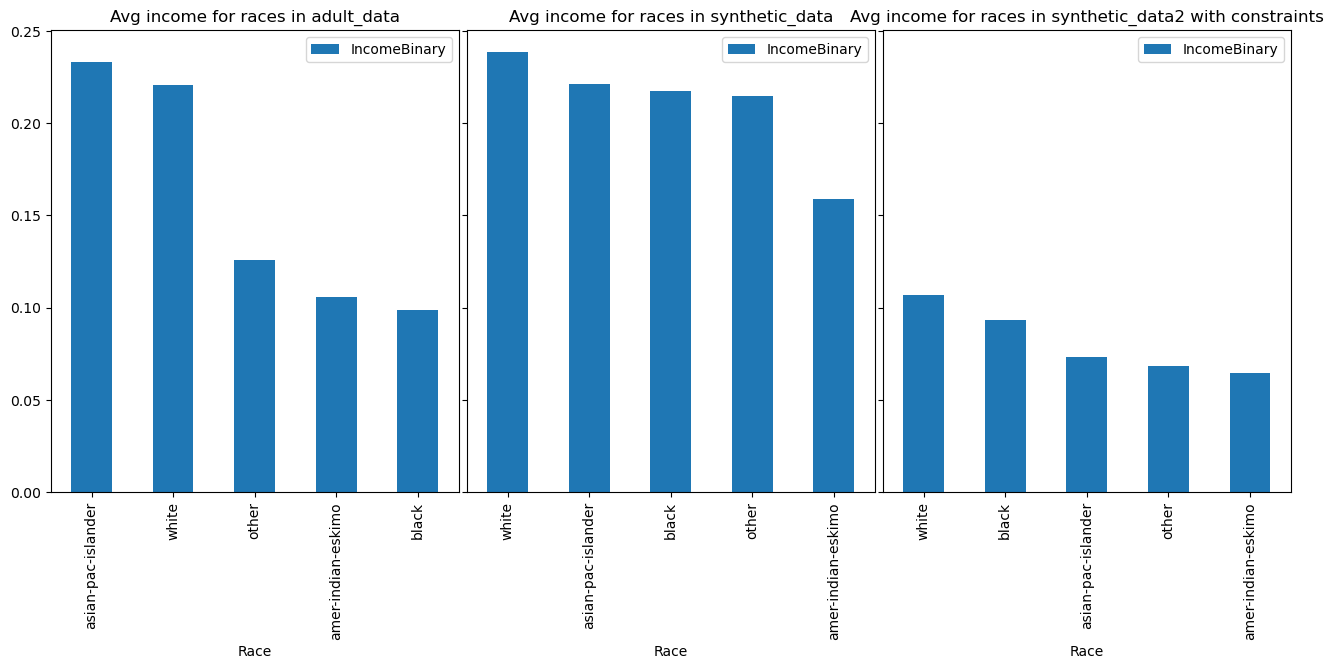

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for races in adult_data", adult_data, 'Race', axs[0])
barplotForAvg("Avg income for races in synthetic_data", synthetic_data, 'Race', axs[1])
barplotForAvg("Avg income for races in synthetic_data2 with constraints", synthetic_data2, 'Race', axs[2])
plt.subplots_adjust(wspace=0.02)
plt.show()

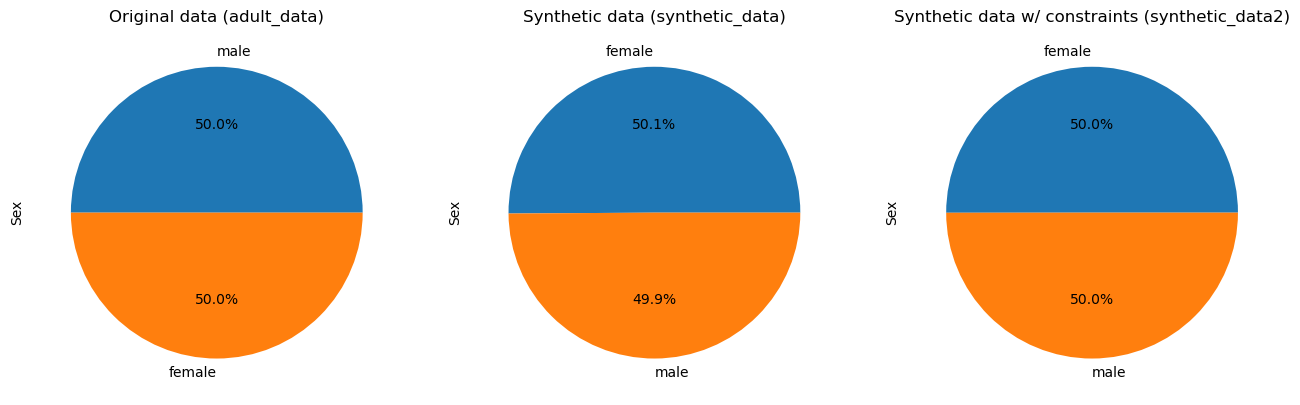

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
piechart(f"Original data (adult_data)", adult_data, axs[0], 'Sex')
piechart(f"Synthetic data (synthetic_data)", synthetic_data, axs[1], 'Sex')
piechart(f"Synthetic data w/ constraints (synthetic_data2)", synthetic_data2, axs[2], 'Sex')
plt.show()

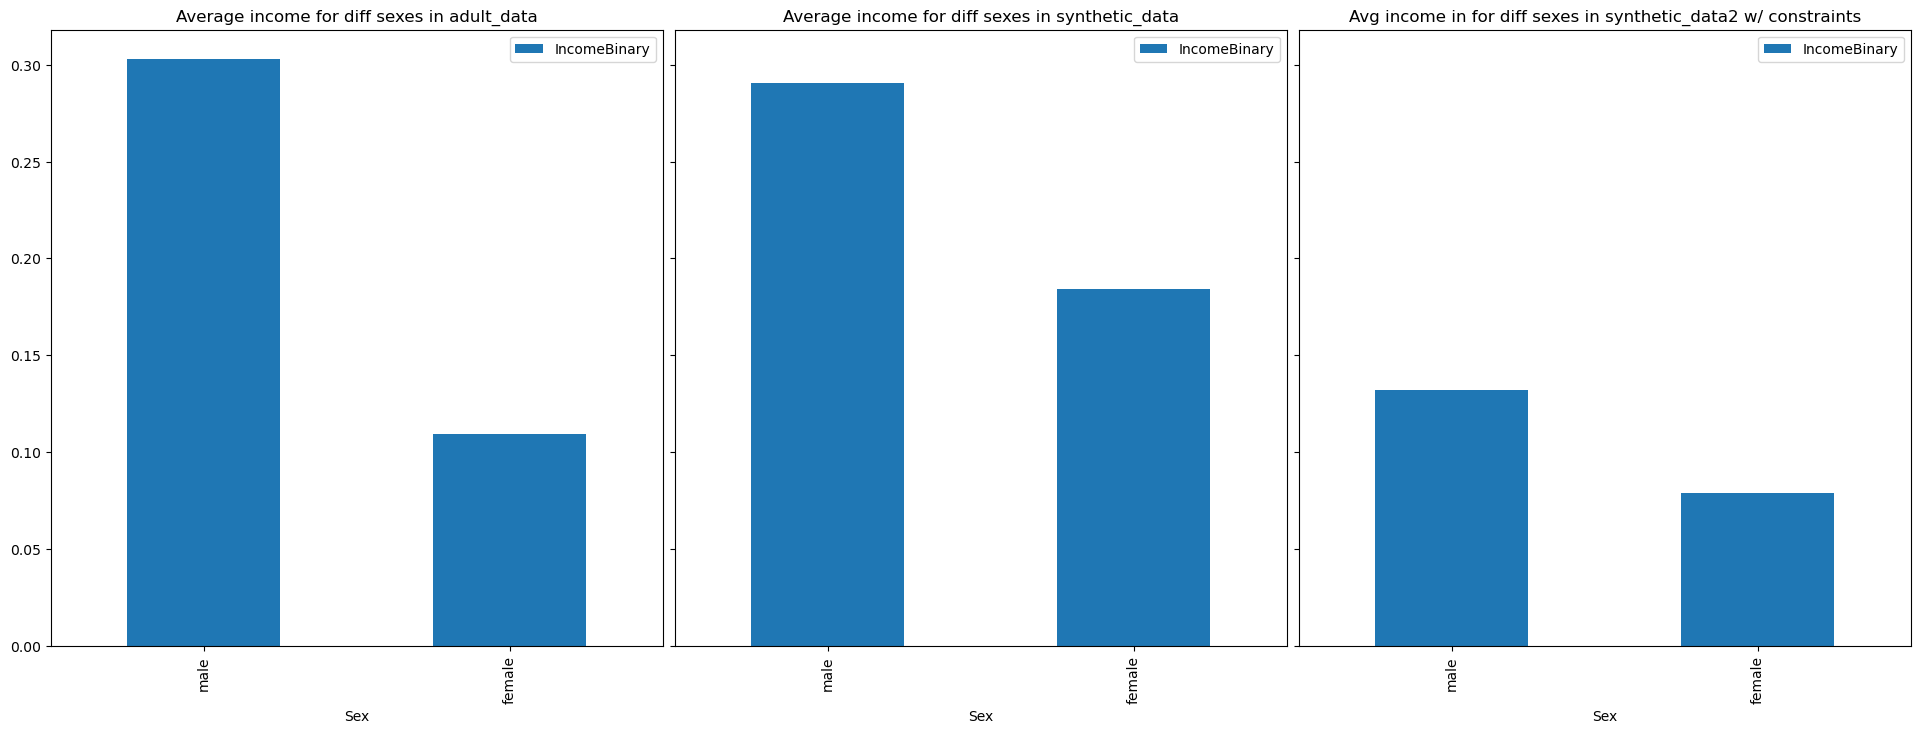

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(24,8), sharey=True)
barplotForAvg("Average income for diff sexes in adult_data", adult_data, 'Sex', axs[0])
barplotForAvg("Average income for diff sexes in synthetic_data", synthetic_data, 'Sex', axs[1])
barplotForAvg("Avg income in for diff sexes in synthetic_data2 w/ constraints", synthetic_data2, 'Sex', axs[2])
plt.subplots_adjust(wspace=0.02)
plt.show()

In [35]:
female_original = adult_data[adult_data['Sex']=='female']
female_original_above50k = female_original.loc[female_original['Income'] == 'morethan50k']
female_synthetic = synthetic_data[synthetic_data['Sex']=='female']
female_synthetic_above50k = female_synthetic.loc[female_synthetic['Income'] == 'morethan50k']
female_synthetic2 = synthetic_data2[synthetic_data2['Sex']=='female']
female_synthetic2_above50k = female_synthetic.loc[female_synthetic['Income'] == 'morethan50k']
print(f"Percent of females earning above 50k in original data (adult_data): {female_original_above50k.shape[0]}/{female_original.shape[0]} = {female_original_above50k.shape[0]/female_original.shape[0]:.3%}")
print(f"Percent of females earning above 50k in synthetic data (synthetic_data): {female_synthetic_above50k.shape[0]}/{female_synthetic.shape[0]} = {female_synthetic_above50k.shape[0]/female_synthetic.shape[0]:.3%}")
print(f"Percent of females earning above 50k in synthetic data (synthetic_data2): {female_synthetic2_above50k.shape[0]}/{female_synthetic2.shape[0]} = {female_synthetic2_above50k.shape[0]/female_synthetic2.shape[0]:.3%}")


Percent of females earning above 50k in original data (adult_data): 1771/16196 = 10.935%
Percent of females earning above 50k in synthetic data (synthetic_data): 1269/16227 = 7.820%
Percent of females earning above 50k in synthetic data (synthetic_data2): 1269/16200 = 7.833%


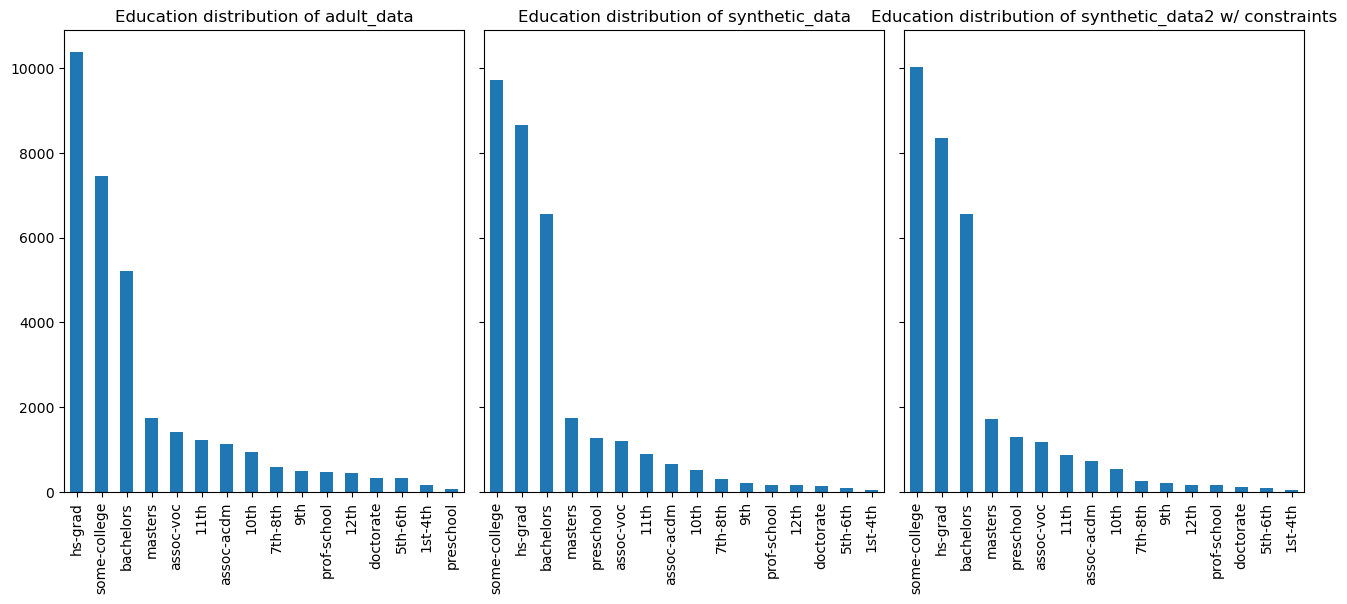

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForCounts(f"Education distribution of adult_data", adult_data, axs[0], 'Education')
barplotForCounts(f"Education distribution of synthetic_data", synthetic_data, axs[1], 'Education')
barplotForCounts(f"Education distribution of synthetic_data2 w/ constraints", synthetic_data2, axs[2], 'Education')
fig.subplots_adjust(wspace=0.05)
plt.show()


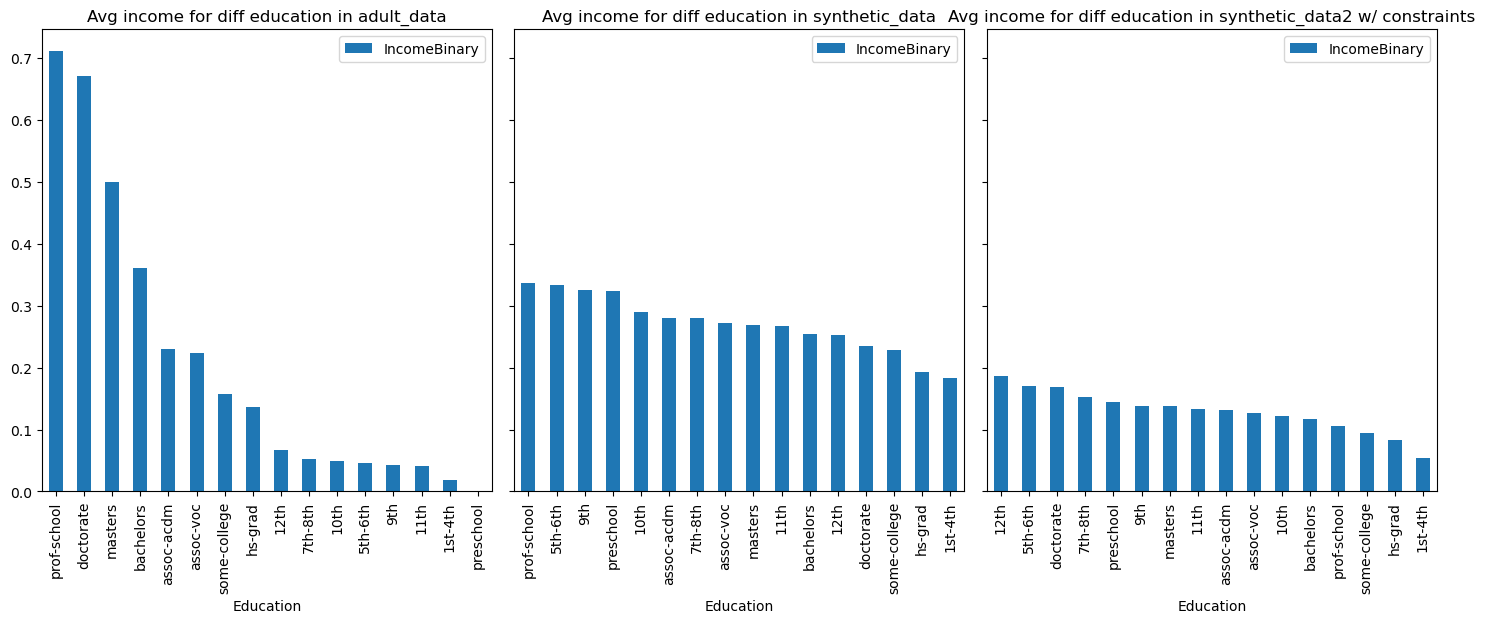

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(18,6), sharey=True)
barplotForAvg("Avg income for diff education in adult_data", adult_data, 'Education', axs[0])
barplotForAvg("Avg income for diff education in synthetic_data", synthetic_data, 'Education', axs[1])
barplotForAvg("Avg income for diff education in synthetic_data2 w/ constraints", synthetic_data2, 'Education', axs[2])
fig.subplots_adjust(wspace=0.05)
plt.show()

In [38]:
synthetic_data2.to_csv('adult.csv',index=False)
adult_data.to_csv('adult_data.csv',index=False)
synthetic_data2.to_csv('adult2.csv',index=False)

In [96]:
%%capture
pip install psycopg2

In [201]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
holoclean_data = pd.read_sql("SELECT * FROM adult_repaired", conn).iloc[:, 1:]

conn.close()

#Alternatively, access the new hospital data from the terminal in holoclean with:  1.   --user postgres     2. \c holo    3. \dt
#4. \copy (SELECT * FROM hospital_repaired) to '/Users/kushagraghosh/Desktop/DataRepairAndFairness/hospital_repaired.csv' with csv header;


/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [203]:
display(holoclean_data)

,Age,Workclass,Education,Maritalstatus,Occupation,Relationship,Race,Sex,HoursPerWeek,Country,Income,IncomeBinary
0,31-50,private,some-college,never-married,prof-specialty,own-child,white,female,45,united-states,lessthan50k,0
1,22-30,private,some-college,married-civ-spouse,machine-op-inspct,husband,white,male,40,united-states,lessthan50k,0
2,31-50,private,some-college,married-civ-spouse,exec-managerial,husband,white,male,40,china,lessthan50k,0
3,>50,private,hs-grad,never-married,machine-op-inspct,other-relative,white,female,40,united-states,lessthan50k,0
4,22-30,private,some-college,never-married,sales,own-child,white,male,40,united-states,lessthan50k,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32387,22-30,private,hs-grad,never-married,other-service,own-child,white,female,40,united-states,lessthan50k,0
32388,31-50,private,some-college,never-married,adm-clerical,own-child,white,male,40,united-states,lessthan50k,0
32389,31-50,private,hs-grad,never-married,other-service,not-in-family,white,male,40,united-states,lessthan50k,0
32390,31-50,private,some-college,never-married,prof-specialty,own-child,white,female,45,united-states,lessthan50k,0


In [209]:
print(holoclean_data.isna().sum().sum())
print(holoclean_data.eq('_nan_').sum().sum())
holoclean_data = holoclean_data.replace('_nan_', np.nan)
holoclean_data['IncomeBinary'] = holoclean_data['IncomeBinary'].astype(int)

3078
0


To check how many tuples were changed using the HoloClean repair process on the original adult data:

In [252]:
comparing_adult = synthetic_data2.compare(holoclean_data)
display(comparing_adult)
print(f"{round(comparing_adult.isna().eq(False).sum().sum()/2)} cells were changed")
print(f"{comparing_adult.shape[0]} tuples (rows) out of a total {synthetic_data2.shape[0]} were changed")

Age         Workclass                Education                \
        self  other       self      other          self         other   
603      NaN    NaN        NaN        NaN           NaN           NaN   
764      NaN    NaN        NaN        NaN           NaN           NaN   
1755     NaN    NaN        NaN        NaN           NaN           NaN   
1846     NaN    NaN        NaN        NaN           NaN           NaN   
1883   18-21    >50    private  local-gov  some-college          10th   
...      ...    ...        ...        ...           ...           ...   
32144  22-30  31-50        NaN        NaN       hs-grad  some-college   
32145    NaN    NaN        NaN        NaN       masters       hs-grad   
32146    >50  22-30        NaN        NaN       7th-8th       masters   
32147  22-30    >50        NaN        NaN     bachelors       7th-8th   
32148    >50  22-30  local-gov    private           NaN           NaN   

            Maritalstatus                           Occupation  \
                     self               other             self   
603                   NaN                 NaN              NaN   
764                   NaN                 NaN              NaN   
1755                  NaN                 NaN              NaN   
1846                  NaN                 NaN              NaN   
1883    married-af-spouse            divorced     craft-repair   
...                   ...                 ...              ...   
32144            divorced   married-af-spouse     craft-repair   
32145       never-married            divorced  exec-managerial   
32146  married-civ-spouse       never-married    other-service   
32147       never-married  married-civ-spouse     adm-clerical   
32148                 NaN                 NaN            sales   

                        ...     Sex         HoursPerWeek        Country  \
                 other  ...    self   other         self  other    self   
603                NaN  ...     NaN     NaN          NaN    NaN     NaN   
764                NaN  ...     NaN     NaN          NaN    NaN     NaN   
1755               NaN  ...     NaN     NaN          NaN    NaN     NaN   
1846               NaN  ...     NaN     NaN          NaN    NaN     NaN   
1883               NaN  ...     NaN     NaN           50     48     NaN   
...                ...  ...     ...     ...          ...    ...     ...   
32144              NaN  ...     NaN     NaN           45     60     NaN   
32145     craft-repair  ...    male  female           50     45     NaN   
32146  exec-managerial  ...  female    male        18-21     50     NaN   
32147    other-service  ...    male  female          NaN    NaN     NaN   
32148     adm-clerical  ...     NaN     NaN           50  18-21     NaN   

                     Income       IncomeBinary        
               other   self other         self other  
603    united-states    NaN   NaN          NaN   NaN  
764    united-states    NaN   NaN          NaN   NaN  
1755   united-states    NaN   NaN          NaN   NaN  
1846   united-states    NaN   NaN          NaN   NaN  
1883             NaN    NaN   NaN          NaN   NaN  
...              ...    ...   ...          ...   ...  
32144            NaN    NaN   NaN          NaN   NaN  
32145            NaN    NaN   NaN          NaN   NaN  
32146            NaN    NaN   NaN          NaN   NaN  
32147            NaN    NaN   NaN          NaN   NaN  
32148            NaN    NaN   NaN          NaN   NaN  

[30269 rows x 24 columns]

176944 cells were changed
30269 tuples (rows) out of a total 32392 were changed


In [215]:
print(f"Proportion of people making > 50k a year in adult_data: {avg_income:.4f}".format(avg_income))
print(f"Proportion of people making > 50k a year in synthetic_data2 with constraints: {avg_income_synthetic2:.4f}")
avg_income_holoclean = np.mean(holoclean_data['IncomeBinary'])
print(f"Proportion of people making > 50k a year in holoclean_data: {avg_income_holoclean:.4f}")

Proportion of people making > 50k a year in adult_data: 0.2076
Proportion of people making > 50k a year in synthetic_data2 with constraints: 0.1059
Proportion of people making > 50k a year in holoclean_data: 0.1059


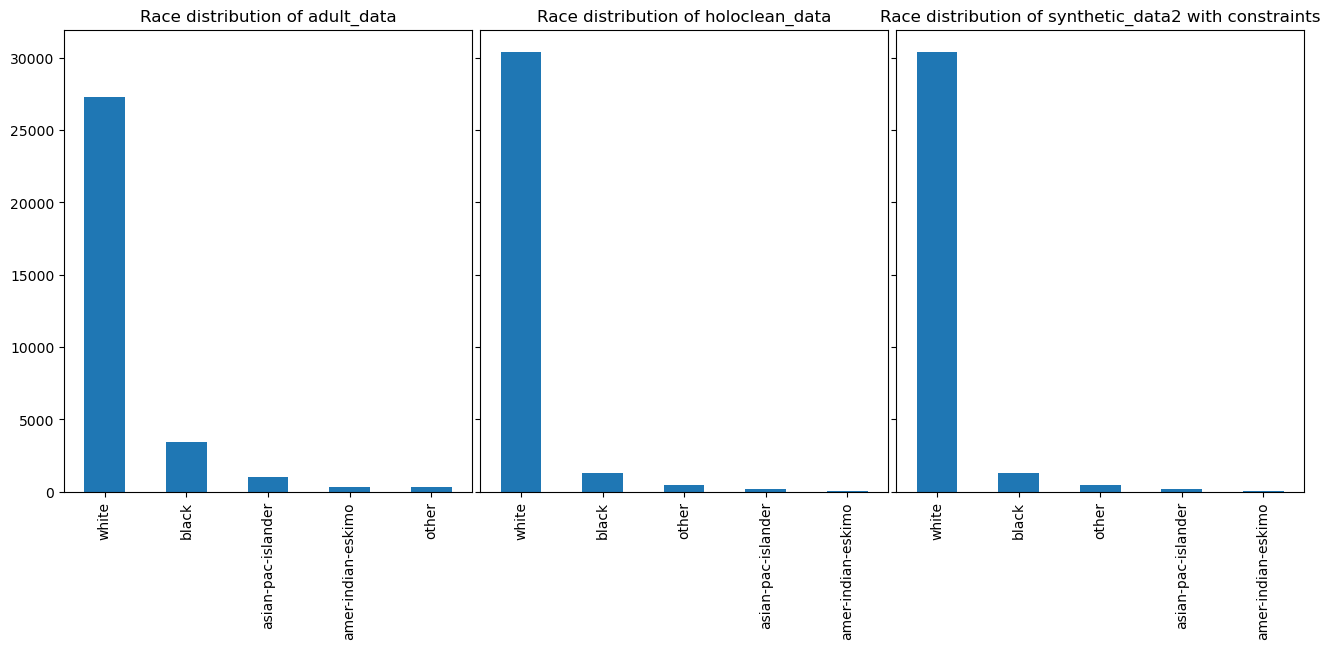

In [238]:
fig, axs = plt.subplots(1,3, figsize=(16,6), sharey=True)
barplotForCounts(f"Race distribution of adult_data", adult_data, axs[0], 'Race')
barplotForCounts(f"Race distribution of holoclean_data", holoclean_data, axs[1], 'Race')
barplotForCounts(f"Race distribution of synthetic_data2 with constraints", synthetic_data2, axs[2], 'Race')
plt.subplots_adjust(wspace=0.02)
plt.show()

# print(adult_data['Race'].value_counts())
# print(synthetic_data['Race'].value_counts())
# print(synthetic_data2['Race'].value_counts())

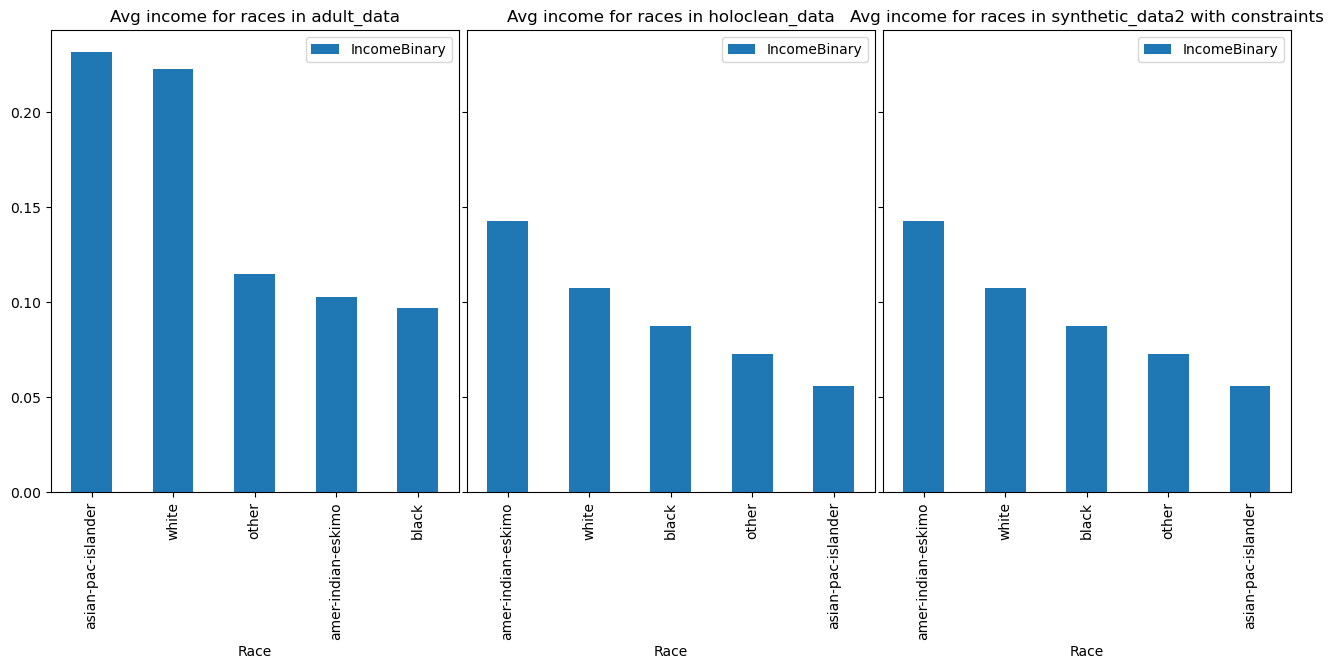

In [239]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for races in adult_data", adult_data, 'Race', axs[0])
barplotForAvg("Avg income for races in holoclean_data", holoclean_data, 'Race', axs[1])
barplotForAvg("Avg income for races in synthetic_data2 with constraints", synthetic_data2, 'Race', axs[2])
plt.subplots_adjust(wspace=0.02)
plt.show()

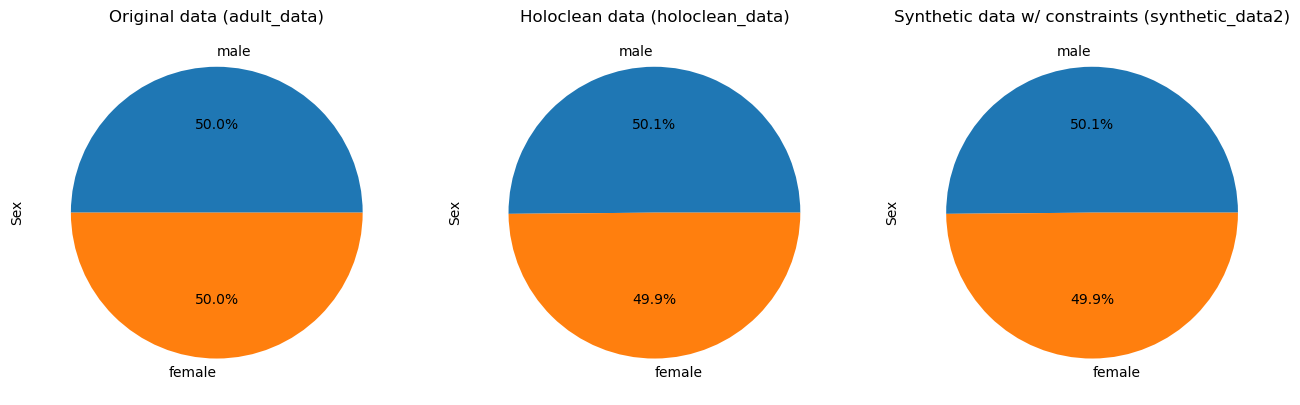

In [240]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
piechart(f"Original data (adult_data)", adult_data, axs[0], 'Sex')
piechart(f"Holoclean data (holoclean_data)", holoclean_data, axs[1], 'Sex')
piechart(f"Synthetic data w/ constraints (synthetic_data2)", synthetic_data2, axs[2], 'Sex')
plt.show()

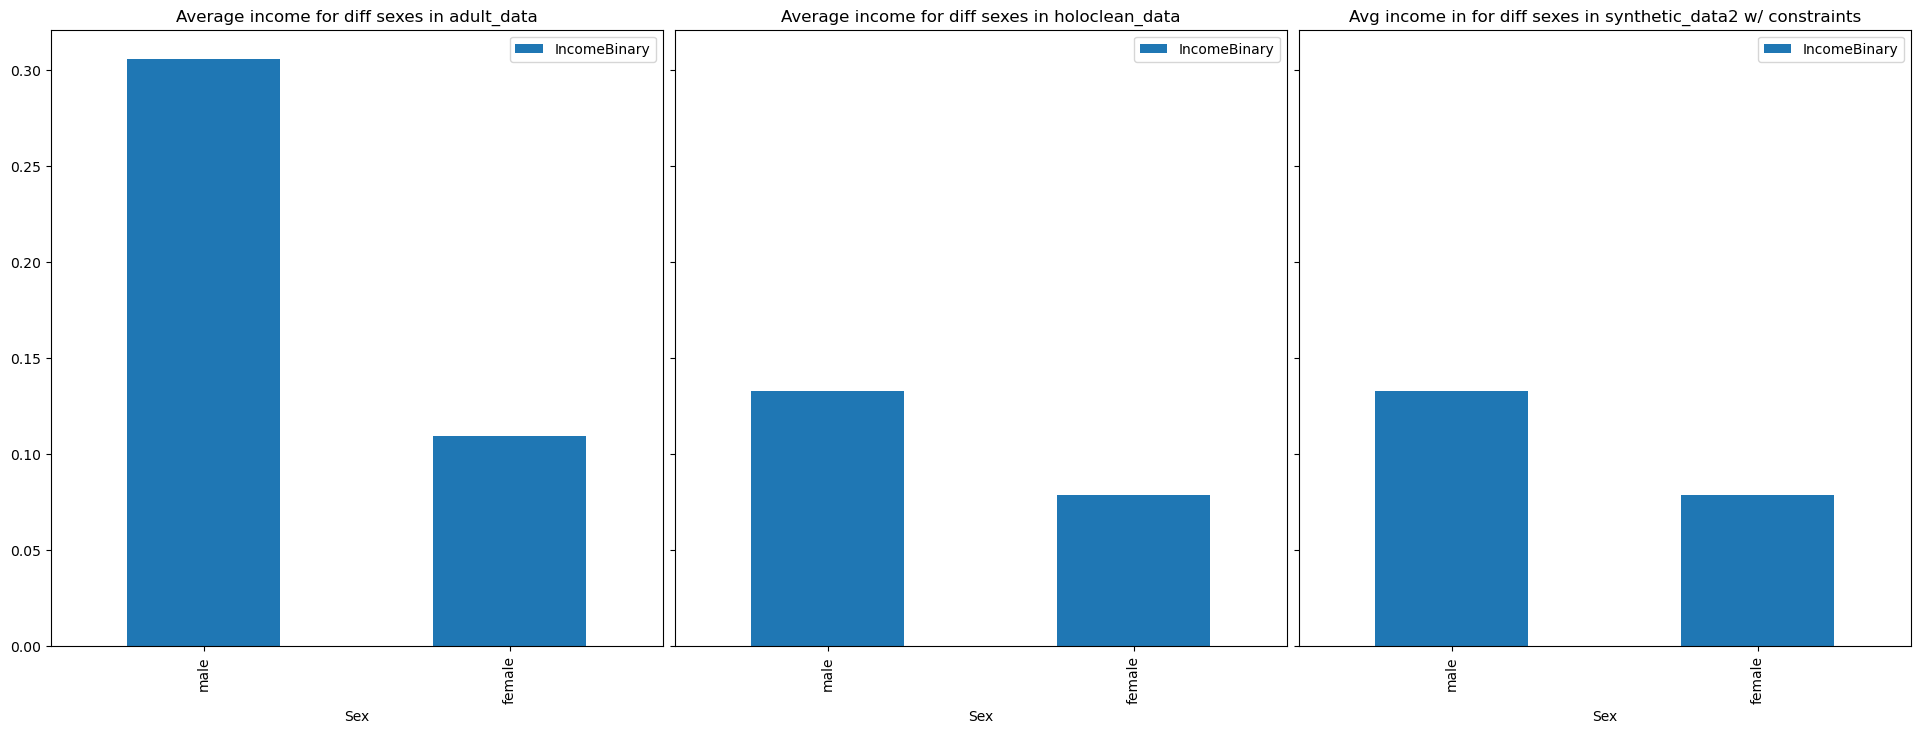

In [241]:
fig, axs = plt.subplots(1, 3, figsize=(24,8), sharey=True)
barplotForAvg("Average income for diff sexes in adult_data", adult_data, 'Sex', axs[0])
barplotForAvg("Average income for diff sexes in holoclean_data", holoclean_data, 'Sex', axs[1])
barplotForAvg("Avg income in for diff sexes in synthetic_data2 w/ constraints", synthetic_data2, 'Sex', axs[2])
plt.subplots_adjust(wspace=0.02)
plt.show()

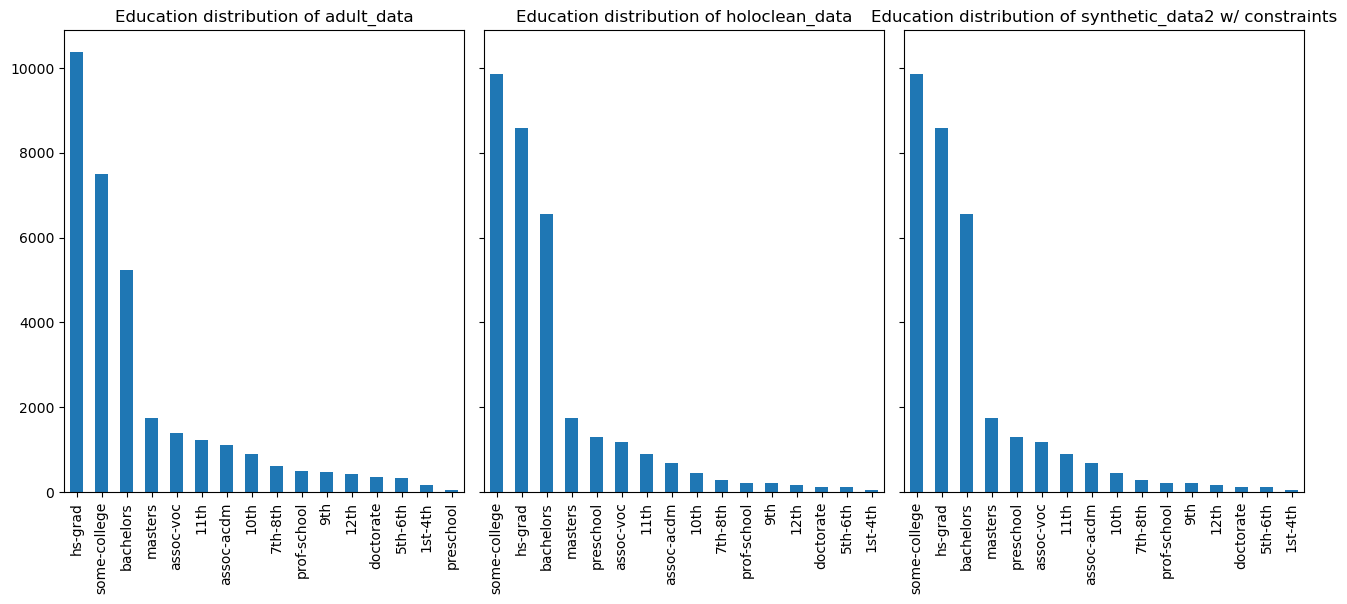

In [242]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForCounts(f"Education distribution of adult_data", adult_data, axs[0], 'Education')
barplotForCounts(f"Education distribution of holoclean_data", holoclean_data, axs[1], 'Education')
barplotForCounts(f"Education distribution of synthetic_data2 w/ constraints", synthetic_data2, axs[2], 'Education')
fig.subplots_adjust(wspace=0.05)
plt.show()

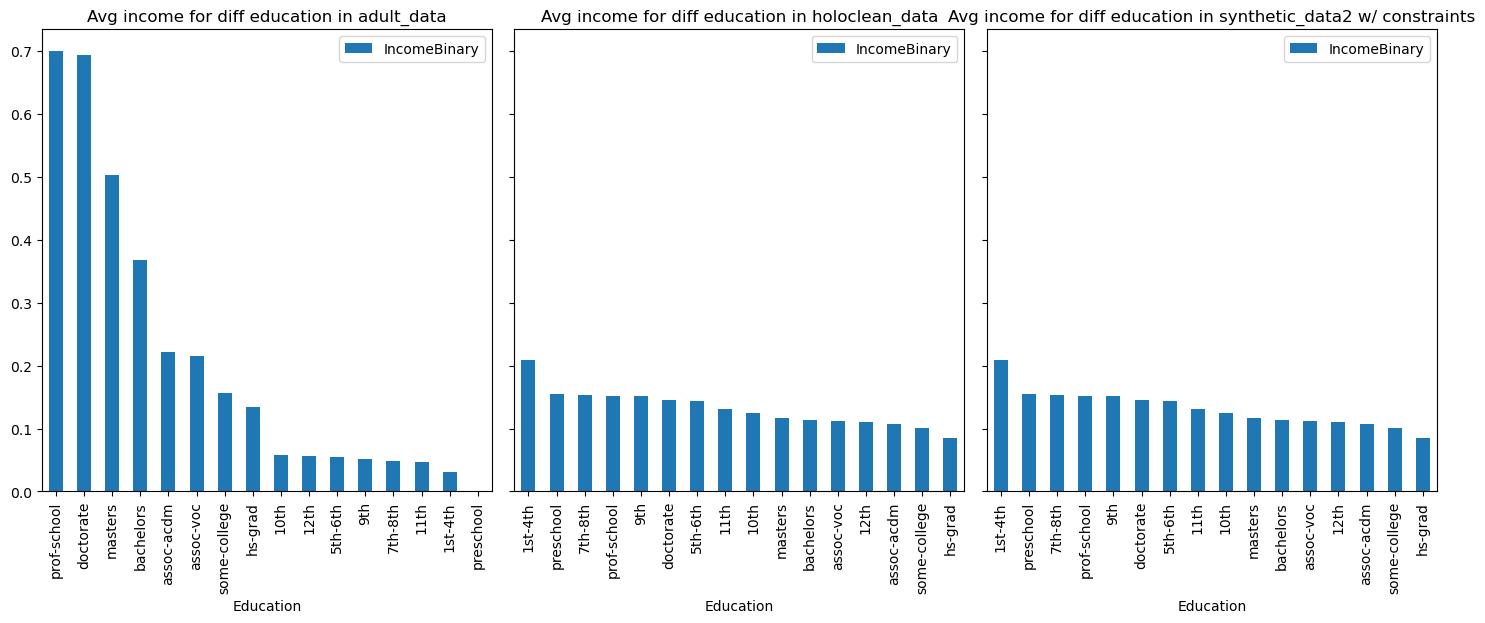

In [243]:
fig, axs = plt.subplots(1, 3, figsize=(18,6), sharey=True)
barplotForAvg("Avg income for diff education in adult_data", adult_data, 'Education', axs[0])
barplotForAvg("Avg income for diff education in holoclean_data", holoclean_data, 'Education', axs[1])
barplotForAvg("Avg income for diff education in synthetic_data2 w/ constraints", synthetic_data2, 'Education', axs[2])
fig.subplots_adjust(wspace=0.05)
plt.show()

In [254]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe holoclean_adultdata
holoclean_adultdata = pd.read_sql("SELECT * FROM adult_data_repaired", conn).iloc[:, 1:]

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [261]:
holoclean_adultdata = holoclean_adultdata.replace('_nan_', np.nan)
holoclean_adultdata['IncomeBinary'] = holoclean_adultdata['IncomeBinary'].astype(int)

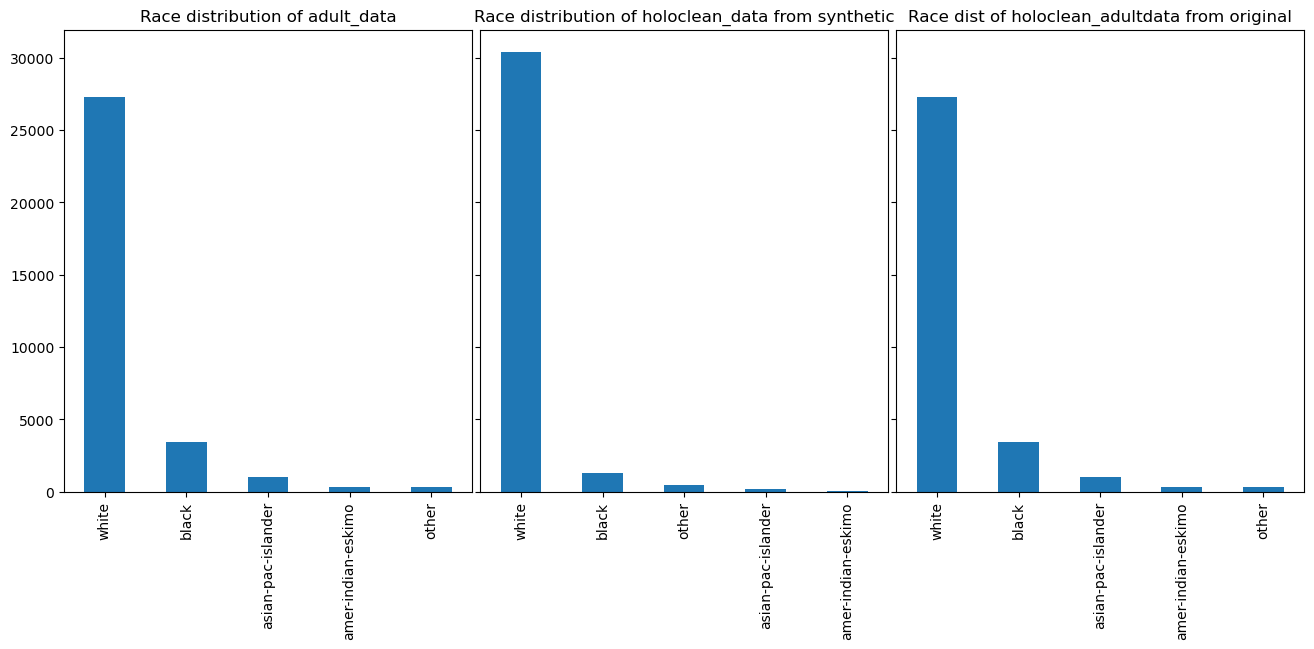

In [262]:
fig, axs = plt.subplots(1,3, figsize=(16,6), sharey=True)
barplotForCounts(f"Race distribution of adult_data", adult_data, axs[0], 'Race')
barplotForCounts(f"Race distribution of holoclean_data from synthetic", holoclean_data, axs[1], 'Race')
barplotForCounts(f"Race dist of holoclean_adultdata from original", holoclean_adultdata, axs[2], 'Race')
plt.subplots_adjust(wspace=0.02)
plt.show()

# print(adult_data['Race'].value_counts())
# print(synthetic_data['Race'].value_counts())
# print(synthetic_data2['Race'].value_counts())

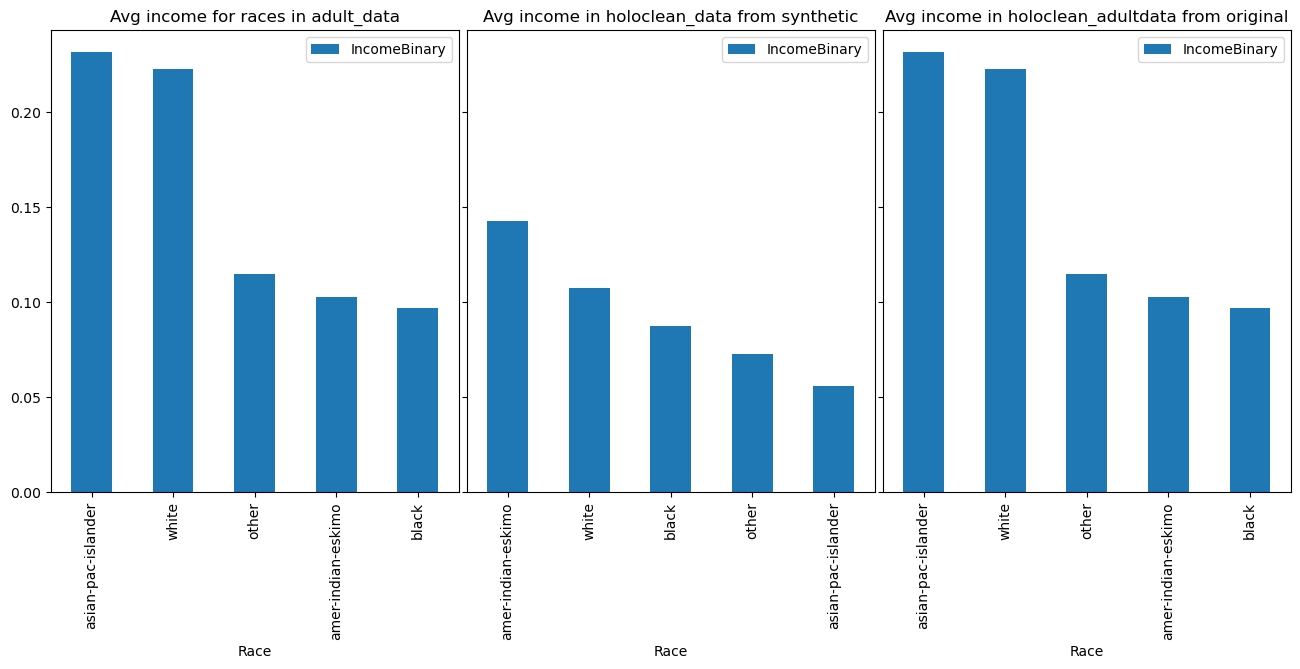

In [263]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for races in adult_data", adult_data, 'Race', axs[0])
barplotForAvg("Avg income in holoclean_data from synthetic", holoclean_data, 'Race', axs[1])
barplotForAvg("Avg income in holoclean_adultdata from original", holoclean_adultdata, 'Race', axs[2])
plt.subplots_adjust(wspace=0.02)
plt.show()

In [277]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe holoclean_adultdata
holoclean_adult2 = pd.read_sql("SELECT * FROM adult2_repaired", conn).iloc[:, 1:]

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [278]:
holoclean_adult2 = holoclean_adult2.replace('_nan_', np.nan)
holoclean_adult2['IncomeBinary'] = holoclean_adult2['IncomeBinary'].astype(int)

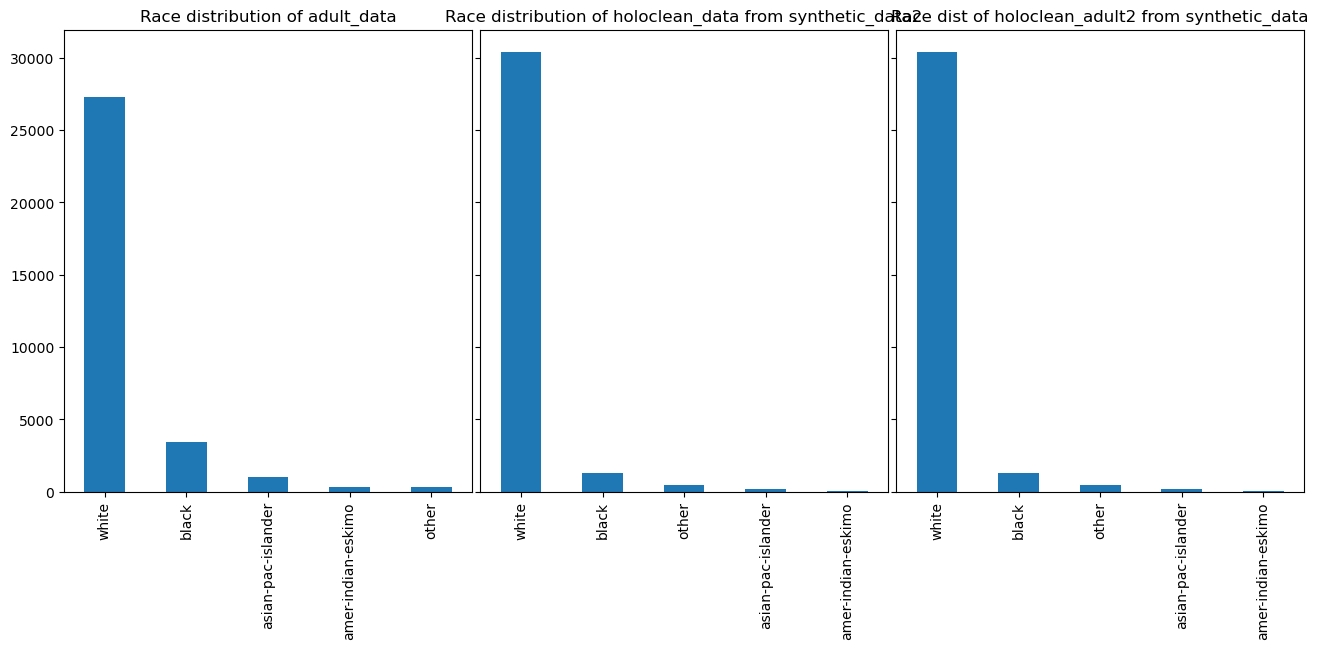

In [279]:
fig, axs = plt.subplots(1,3, figsize=(16,6), sharey=True)
barplotForCounts(f"Race distribution of adult_data", adult_data, axs[0], 'Race')
barplotForCounts(f"Race distribution of holoclean_data from synthetic_data2", holoclean_data, axs[1], 'Race')
barplotForCounts(f"Race dist of holoclean_adult2 from synthetic_data", holoclean_adult2, axs[2], 'Race')
plt.subplots_adjust(wspace=0.02)
plt.show()


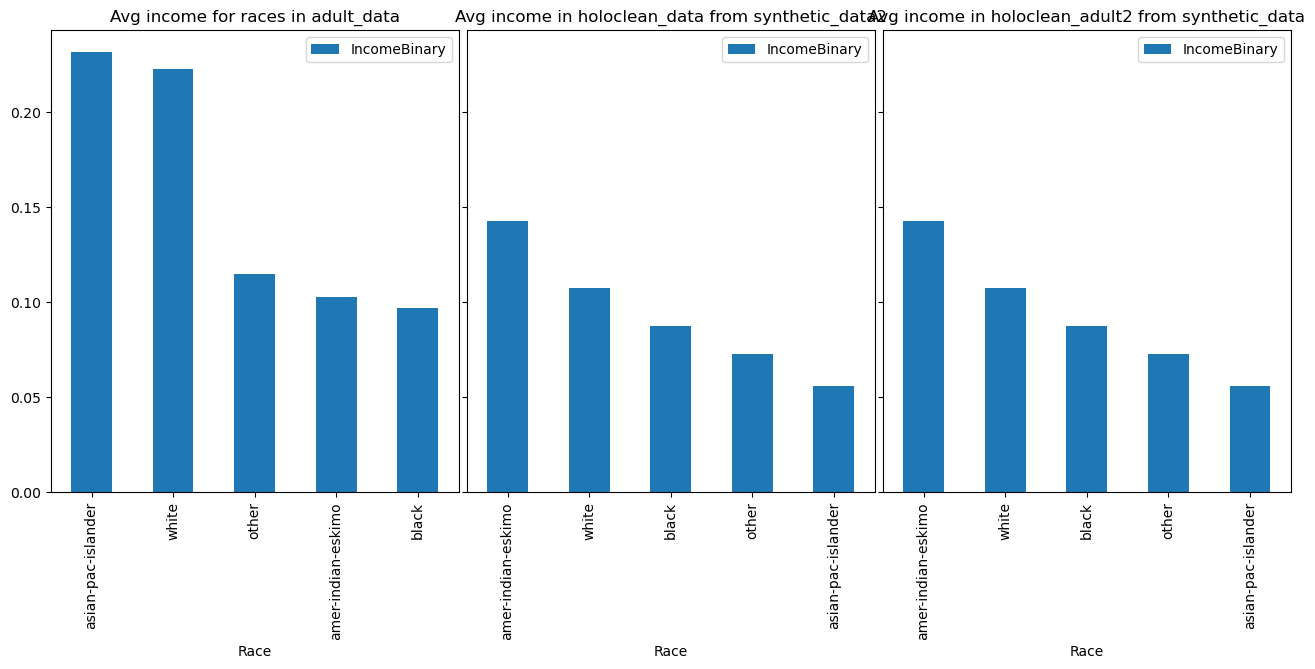

In [280]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for races in adult_data", adult_data, 'Race', axs[0])
barplotForAvg("Avg income in holoclean_data from synthetic_data2", holoclean_data, 'Race', axs[1])
barplotForAvg("Avg income in holoclean_adult2 from synthetic_data", holoclean_adult2, 'Race', axs[2])
plt.subplots_adjust(wspace=0.02)
plt.show()

In [281]:
print(f"Proportion of people making > 50k a year in adult_data: {avg_income:.4f}".format(avg_income))
print(f"Proportion of people making > 50k a year in synthetic_data: {avg_income_synthetic:.4f}")
print(f"Proportion of people making > 50k a year in synthetic_data2 with constraints: {avg_income_synthetic2:.4f}")
print(f"Proportion of people making > 50k a year in holoclean_data (cleaned synthetic_data2): {avg_income_holoclean:.4f}")
avg_income_holoclean_adultdata = np.mean(holoclean_adultdata['IncomeBinary'])
print(f"Proportion of people making > 50k a year in holoclean_adultdata (cleaned adult_data): {avg_income_holoclean_adultdata:.4f}")
avg_income_holoclean_adult2 = np.mean(holoclean_adult2['IncomeBinary'])
print(f"Proportion of people making > 50k a year in holoclean_adult2 (cleaned synthetic_data): {avg_income_holoclean_adult2:.4f}")

Proportion of people making > 50k a year in adult_data: 0.2076
Proportion of people making > 50k a year in synthetic_data: 0.2360
Proportion of people making > 50k a year in synthetic_data2 with constraints: 0.1059
Proportion of people making > 50k a year in holoclean_data (cleaned synthetic_data2): 0.1059
Proportion of people making > 50k a year in holoclean_adultdata (cleaned adult_data): 0.2076
Proportion of people making > 50k a year in holoclean_adult2 (cleaned synthetic_data): 0.1059
